# Project Info .... names , abstract , ... #TODO

# Part1 - BERT Fine-Tuning

In [ ]:
# In the name of God
# Deep Learning Project
# Dr. Fatemizadeh

# Import necessary libraries

########## Plan 1
!pip -q install transformers

########## Plan 2
#!pip install transformers -U

########## Plan 3
# !pip install tokenizers==0.11.1
# !pip install transformers -U


#import os

import torch
import numpy as np
from torch.utils.data import DataLoader, Dataset

import torch.nn as nn
from transformers import AdamW
from transformers import get_linear_schedule_with_warmup# for scheduler!

#from sklearn.metrics import f1_score

import matplotlib.pyplot as plt
#from sklearn.metrics import confusion_matrix
import torch
from transformers import AutoTokenizer, AutoModel

## The new BERT model
from transformers import BertTokenizer, BertForSequenceClassification


import random
import json
import time
student_names = "\nNavid Farmahini Farahani\nMatin Armanmehr\nSajjad Hashembeiki"

print("Names of students:", student_names)


Names of students: 
Navid Farmahini Farahani
Matin Armanmehr
Sajjad Hashembeiki


In [ ]:

seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
if torch.cuda.is_available():
  torch.cuda.manual_seed_all(seed_val)

In [ ]:
!gdown 1oh9c-d0fo3NtETNySmCNLUc6H1j4dSWE
!gdown 1k5LMwmYF7PF-BzYQNE2ULBae79nbM268

Downloading...
From: https://drive.google.com/uc?id=1oh9c-d0fo3NtETNySmCNLUc6H1j4dSWE
To: /content/subtaskB_dev.jsonl
100% 4.93M/4.93M [00:00<00:00, 208MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1k5LMwmYF7PF-BzYQNE2ULBae79nbM268
From (redirected): https://drive.google.com/uc?id=1k5LMwmYF7PF-BzYQNE2ULBae79nbM268&confirm=t&uuid=554a8a8e-0737-435e-b15d-0d85b6f27d70
To: /content/subtaskB_train.jsonl
100% 155M/155M [00:02<00:00, 75.7MB/s]


In [ ]:
# We use this function for changing the device
def to_device(data, device):
    # for every batch, we pass the data to the current device.
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)


# We use this class for passing the data and model to the device
class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl=dl
        self.device=device

    def __iter__(self):
        #For every batch, we pass it to the current device.
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        return len(self.dl)

# Selecting the current device
if torch.cuda.is_available():
      device=torch.device('cuda')
else:
      device=torch.device('cpu')

print("The device is:",device)


The device is: cuda


In [ ]:
# ## Loading Tokenizer
# bert_tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
# bert_tokenizer.pad_token = bert_tokenizer.eos_token
# bert_tokenizer.add_special_tokens({"pad_token": "[PAD]"})

# ## Loading Model
# bert_model = AutoModel.from_pretrained('bert-base-uncased')
# bert_model = to_device(bert_model, device)


## New Tokenizer (Beta)
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
# bert_tokenizer.pad_token = bert_tokenizer.eos_token
# bert_tokenizer.add_special_tokens({"pad_token": "[PAD]"})

## New BERT Classifier Model (Beta)
num_class = 6
#bert_model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=num_class,ignore_mismatched_sizes=True,)
bert_model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=num_class)
#bert_model = BertForSequenceClassification.from_pretrained('bert-base-uncased')
#bert_model = BertForSequenceClassification.from_pretrained('bert-base-cased', num_labels=num_class)
bert_model = to_device(bert_model, device)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
## Load dataset and make list of texts and their labels

all_texts=[]
all_labels=[]
with open('subtaskB_train.jsonl','r') as f:
  for line in f:
          data = json.loads(line)
          all_texts.append(data['text'])
          all_labels.append(data['label'])

all_texts_test=[]
all_labels_test=[]
lennns=[]
with open('subtaskB_dev.jsonl','r') as f:
  for line in f:
          data = json.loads(line)
          all_texts_test.append(data['text'])
          all_labels_test.append(data['label'])
          lennns.append(len(data['text']))


In [ ]:
print(len(all_texts))

print(max(lennns))

print(np.where(np.array(lennns)==max(lennns)))

# print(all_texts_test[765])

71027
7595
(array([765]),)


In [ ]:
# dataset2_indexes=np.linspace(0,50000,50000,dtype=np.uint32)
# num_images=3000
# np.random.shuffle(dataset2_indexes)
# dataset2_indexes_lower_volume = dataset2_indexes[0:num_images]

# all_texts_samp = np.array(all_texts)[dataset2_indexes_lower_volume]


# np.random.shuffle(the_list)
# print(the_list)



############### Sampling ( I think this part is not necessary)


# pick_persentage=0.1
# the_list=list(range(0,len(all_texts)))
# selector=the_list[0:int(pick_persentage*len(all_texts))]
# np.random.shuffle(selector)

# print(selector)

# all_texts_samp=[]
# all_labels_samp=[]

# for i in range(len(selector)):
#   all_texts_samp.append(all_texts[selector[i]])
#   all_labels_samp.append(all_labels[selector[i]])


# print(len(all_texts_samp))
# print(len(all_texts))



###############









#### Shuffling the dataset


the_list=list(range(0,len(all_texts)))
selector=the_list[0:int(len(all_texts))]
np.random.shuffle(selector)

print(selector)

all_texts_shuffled=[]
all_labels_shuffled=[]
all_labels_masks=torch.ones(len(all_labels),dtype=bool).to(device)
for i in range(len(selector)):
  all_texts_shuffled.append(all_texts[selector[i]])
  all_labels_shuffled.append(all_labels[selector[i]])


print(len(all_texts_shuffled))
print(len(all_texts))

##### Semisupervised Dataset( We consider 1-percentage of the data to -1)

percentage=0.05

#all_labels_shuffled_psudo=all_labels_shuffled
for i in range(int(percentage*len(all_texts_shuffled)),len(all_texts_shuffled)):
  all_labels_masks[i]=False
  # all_labels_shuffled[i] = 10
#####


# print(all_labels_samp)
# print(all_texts_samp)


# print(all_texts[selector])


[27763, 21738, 38676, 17208, 6348, 28496, 64158, 48462, 22014, 68073, 39820, 24921, 70056, 3935, 17598, 51537, 11615, 42439, 34379, 20627, 64303, 39858, 5398, 13889, 59604, 40377, 53239, 47520, 66070, 62186, 37576, 26537, 52778, 45877, 13927, 38777, 70861, 58467, 40001, 44820, 46406, 12532, 50337, 69182, 7823, 22919, 24679, 1181, 32114, 56687, 11756, 39665, 67233, 24141, 501, 41658, 39610, 7168, 66657, 35482, 42079, 55000, 27171, 29800, 55164, 16344, 57523, 62747, 17553, 59504, 68969, 67583, 32034, 43285, 42984, 30648, 69464, 2968, 26338, 13938, 10369, 38147, 28909, 14796, 35180, 35170, 41162, 61428, 39068, 24473, 51169, 1491, 6692, 46561, 30971, 65317, 9889, 5083, 60418, 19469, 45359, 63056, 40573, 46282, 7167, 50734, 7781, 29020, 10406, 34238, 49499, 50879, 67689, 51467, 30724, 53250, 30303, 59479, 38792, 63365, 26977, 32182, 44756, 7499, 41904, 16810, 33467, 26103, 25750, 6432, 19153, 17834, 1213, 52232, 17731, 28741, 58534, 32741, 59690, 11504, 55303, 23008, 4563, 11535, 28075, 655

In [ ]:
# print(data)
# for i in range(len(all_data)):
#   print(all_data[i]['label'])
# print(data['source'])
# print(data["wikihow"])
#print(all_data[15]["label"])
#all_data[15]['text']
#all_data[15]['model']


# id shows the order
# label shows the label(chat gpt, human , etc)
# model is not important
#

In [ ]:
# max_len = max([len(k) for k in all_texts])
# print(max_len)
# max_len=10*512
# text_test = all_texts[0]
# # print(text_test)

# text_test_tk = bert_tokenizer(text_test,
#                               padding='max_length',
#                               max_length = max_len,
#                               return_tensors="pt",
#                               truncation = True).to(device)

# print(text_test_tk['input_ids'].shape)

# text_test_tk['input_ids']=text_test_tk['input_ids'].reshape([max_len//512,512])
# text_test_tk['attention_mask'] =text_test_tk['attention_mask'].reshape([max_len//512,512])

# print(text_test_tk['input_ids'].shape)
# print(text_test_tk['attention_mask'].shape)
# out = bert_model(text_test_tk['input_ids'], attention_mask = text_test_tk['attention_mask'])
# print(out[0].shape)
# print(out[1].shape)
# # bert_model.generate(text_test_tk['input_ids'], attention_mask = text_test_tk['attention_mask'])


In [ ]:
bert_model.parameters

<bound method Module.parameters of BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (Layer

In [ ]:
# class BERT_Dataset(Dataset):
#   def __init__(self, text, labels, max_len):
#     self.text = text
#     self.labels = labels
#     self.max_len = max_len

#   def __getitem__(self,index):

#     tokenized_text = bert_tokenizer(self.text[index],
#                                     padding='max_length',
#                                     max_length = 512,
#                                     # max_length = self.max_len,
#                                     return_tensors="pt",
#                                     truncation = True)

#     #return tokenized_text['input_ids'].to(torch.float16), tokenized_text['attention_mask'].to(torch.float16), self.labels[index]
#     # return tokenized_text['input_ids'].squeeze().to(torch.float16), tokenized_text['attention_mask'].squeeze().to(torch.float16), self.labels[index]
#     return tokenized_text['input_ids'].squeeze(), tokenized_text['attention_mask'].squeeze(), self.labels[index]
#   def __len__(self):
#     return len(self.labels)


################# NEW DATASET (BETA) #######################

class BERT_Dataset(Dataset):
  def __init__(self, text, labels,label_masks, max_len):
    self.text = text
    self.labels = np.array(labels)# np.array!!
    self.label_masks=label_masks
    self.max_len = max_len
    # self.percentage=percentage

    # if (self.percentage != 1):
    #  self.labels[int(self.percentage*len(self.labels)):]=-1



  def __getitem__(self,index):
    # tokenized_text = bert_tokenizer(self.text[index],
    #                                   padding='max_length',
    #                                   max_length = 512,
    #                                   return_tensors="pt",
    #                                   truncation = True,
    #                                   # return_masked_tokens=True,
    #                                 )



    #  I did not use ""return_token_type_ids"" in the following tokenizer =False

    tokenized_text = bert_tokenizer.encode_plus(self.text[index],
                                          max_length = 512,
                                          return_tensors="pt",
                                          truncation = True,
                                          add_special_tokens=True,
                                          padding="max_length",
                                          return_attention_mask=True
                                          # return_masked_tokens=True,
                                        )

    # if (self.labels[index]==-1):
    #   mask_for_label=np.zeros(1,dtype=np.uint8)
    # else:
    #   mask_for_label=np.ones(1,dtype=np.uint8)
    #return tokenized_text.input_ids.squeeze(), tokenized_text.attention_mask.squeeze(), tokenized_text.token_type_ids.squeeze(),self.labels[index]
    return tokenized_text.input_ids.squeeze(), tokenized_text.attention_mask.squeeze(), tokenized_text.token_type_ids.squeeze(),self.labels[index],self.label_masks[index]


  def __len__(self):
    return len(self.text)


######################################################

# class BERT_Dataset(Dataset):
#     def __init__(self, text, labels, window_size):
#         self.text = text
#         self.labels = labels
#         self.window_size = window_size
#         self.max_len = max([len(k) for k in text])

#     def __getitem__(self, index):
#         windowed_text = self.text[index]
#         num_windows = len(windowed_text) // self.window_size

#         inputs = []
#         masks = []

#         for i in range(num_windows):
#             start_idx = i * self.window_size
#             end_idx = (i + 1) * self.window_size

#             tokenized_text = bert_tokenizer(
#                 windowed_text[start_idx:end_idx],
#                 padding="max_length",
#                 max_length=513,  # Increase by 1 for the [CLS] token
#                 return_tensors="pt",
#                 truncation=True,
#             )

#             inputs.append(tokenized_text["input_ids"].squeeze().to(torch.float16))
#             masks.append(tokenized_text["attention_mask"].squeeze().to(torch.float16))

#         labels = [self.labels[index]] * num_windows

#         return inputs, masks, labels

#     def __len__(self):
#         return len(self.labels)




In [ ]:
batch_size = 4
# max_len = int(pick_persentage*np.ceil(max(lennns)/512)*512)
max_len = int(np.ceil(max(lennns)/512)*512)
print('max_len:',max_len)



train_dataset_with_label = BERT_Dataset(text = all_texts_shuffled[:int(percentage*len(all_texts_shuffled))],
                             labels = all_labels_shuffled[:int(percentage*len(all_texts_shuffled))],
                             label_masks=all_labels_masks[:int(percentage*len(all_texts_shuffled))],
                             max_len = max_len)


train_loader_with_label = DataLoader(train_dataset_with_label, batch_size = batch_size, shuffle = False)


train_loader_with_label = DeviceDataLoader(train_loader_with_label, device)


test_dataset = BERT_Dataset(text = all_texts_test,
                            labels = all_labels_test,
                            label_masks=torch.ones(len(all_labels_test)).to(device),
                            max_len = max_len)


print(len(train_dataset_with_label))
print(len(test_dataset))

test_loader = DataLoader(test_dataset, batch_size = batch_size, shuffle = True)
test_loader = DeviceDataLoader(test_loader, device)



max_len: 7680
3551
3000


In [ ]:
# print(train_dataset[70000])

print(train_dataset_with_label[0])


(tensor([  101,  1045,  3685,  3437,  2115,  3160,  2000,  2440,  6698,  1010,
         2054,  1045,  2079,  2113,  2003,  2008, 13125,  5228,  1996,  2206,
         5936,  2000,  1996,  2413,  4750,  2283,  4953,  5719,  2007,  1996,
         4750,  4329, 16865,  4383,  6043,  1024,  1008,  1000,  3393, 11503,
         5400,  3207, 13125,  2063,  4654, 24759,  7413, 24209,  1005,  6335,
         1037, 11113,  8551,  2063,  8292,  4674,  3160, 27985,  2063, 24209,
         1005,  6335, 11320,  2072,  7367, 19661, 10861,  4649,  4750,  2229,
         1050,  1005,  2006,  2102, 14674, 19493,  4012, 18098,  2483, 10861,
         2474,  3663,  1037,  2689,  4372,  2605,  1012,  4649,  4750,  2229,
         1050,  1005,  4372,  5495, 10087,  3372,  8740, 10841,  2078,  4012,
        13876,  2063,  3802,  3613,  3372,  1037, 24086, 12229,  1048,  1005,
         2019, 23402, 10087,  5622, 10177,  2632,  5668, 10861,  2474,  3663,
         1037,  2689,  1012,  1031,  1012,  1012,  1012,  1033,

In [ ]:
## Test of Dataloader

# print(all_texts_test[0])
# text_0 = bert_tokenizer(all_texts_test[0],
#                                   padding='max_length',
#                                   max_length = 128,
#                                   # max_length = self.max_len,
#                                   return_tensors="pt",
#                                   truncation = True)
# print('\n\n\n')
# text_0 = bert_tokenizer.decode(text_0['input_ids'][0], skip_spetial_tokens=True)


# print(text_0)


# for text, att, tk_type, label in train_loader_with_label:
#   #print(tk_type.to(device).shape)
#   print(label)
#   #break



In [ ]:
########################


# class BERT_Arch(nn.Module):
#    def __init__(self, bert, intents):
#       super(BERT_Arch, self).__init__()
#       # Freeze BERT SECTION
#       self.bert = bert
#       self.intents = intents

#       # for param in self.bert.parameters():
#       #     param.requires_grad = False

#       self.fc2 = nn.Sequential(nn.Linear(768,256),
#                                nn.ReLU(),
#                                nn.Linear(256,self.intents),
#                                nn.Softmax(dim=1),
#                                )

#        # relu activation function
#        #  self.relu =  nn.ReLU()
#        # dense layer

#    def forward(self, sent_id, mask):
#       #pass the inputs to the model
#       # cls_hs = self.bert(sent_id, attention_mask=mask)[0][:,0]
#       cls_hs = self.bert(sent_id, attention_mask=mask)[0]
#       cls_hs = torch.mean(cls_hs,dim=1).squeeze()
#       x = self.fc2(cls_hs)
#       return x

# class BERT_ARCH2(nn.Module):

#     def __init__(self, n_classes):
#       super(BERT_ARCH2, self).__init__()
#       #self.bert = BertForSequenceClassification.from_pretrained('bert-base-uncased')
#       self.bert=BertModel.from_pretrained('bert-base-uncased')
#       self.drop = nn.Dropout(p=0.3)
#       self.out = nn.Linear(self.bert.config.hidden_size, n_classes)

#     def forward(self, input_ids, attention_mask):
#         _, pooled_output = self.bert(
#         input_ids=input_ids,
#         attention_mask=attention_mask)

#       print("Hello",pooled_output)

#       output = self.drop(pooled_output)
#       return self.out(output)


######################

In [ ]:
######### NEW BERT MODEL (BETA) #############

# Define hyperparameters
learning_rate = 2e-5
epochs = 3

# bert_model2=BERT_ARCH2(num_class)
optimizer = torch.optim.AdamW(bert_model.parameters(), lr=learning_rate)
loss_fn = torch.nn.CrossEntropyLoss()

total_steps = len(train_loader_with_label) * epochs


print(total_steps)


scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)


# bert_model2=to_device(bert_model2,device)
total_loss_for_all_epochs=[]
total_acc_for_all_epochs=[]
# Training loop
tic=time.time()
for epoch in range(epochs):
    bert_model.train()
    total_loss=[]
    total_acc=[]
    total_samples= 0
    total_correct= 0
    i=0
    for batch in train_loader_with_label:
        i=i+1
        input_ids, attention_mask, token_type_ids, label,_ = batch
        # input_ids, attention_mask, token_type_ids, label = (
        #     input_ids.to(device),
        #     attention_mask.to(device),
        #     token_type_ids.to(device),
        #     label.to(device),
        # )

        optimizer.zero_grad()


        outputs = bert_model(input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids, labels=label)


        #loss=loss_fn(outputs.logits,label)
        loss = outputs.loss



        total_loss.append(loss.item())
        total_loss_for_all_epochs.append(loss.item())
        loss.backward()
        optimizer.step()
        scheduler.step()
        print("Step:",i,"  From",len(train_dataset_with_label)//batch_size, "  Loss:",loss.item())
        _, preds = torch.max(outputs[1], dim = 1)
        total_samples += label.size(0)
        total_correct += (preds == label).sum().item()


        if i%20 == 0:
          acc_train=100*total_correct/total_samples

          print("Train Accuracy For 20 Steps: ",acc_train,"%")
          total_correct=0
          total_samples=0
          total_acc.append(acc_train)
          total_acc_for_all_epochs.append(acc_train)

    print(f"Epoch {epoch + 1}/{epochs}")
    print("Average Train Loss:", torch.mean(torch.tensor(total_loss)),"Average Train Accuracy:", torch.mean(torch.tensor(total_acc)))




2664
Step: 1   From 887   Loss: 1.516376256942749
Step: 2   From 887   Loss: 1.9868543148040771
Step: 3   From 887   Loss: 1.7658040523529053
Step: 4   From 887   Loss: 1.596841812133789
Step: 5   From 887   Loss: 1.7412129640579224
Step: 6   From 887   Loss: 2.111514091491699
Step: 7   From 887   Loss: 1.494077444076538
Step: 8   From 887   Loss: 1.8946599960327148
Step: 9   From 887   Loss: 1.9908183813095093
Step: 10   From 887   Loss: 1.9925439357757568
Step: 11   From 887   Loss: 2.0460140705108643
Step: 12   From 887   Loss: 2.0292561054229736
Step: 13   From 887   Loss: 1.9923877716064453
Step: 14   From 887   Loss: 1.7171804904937744
Step: 15   From 887   Loss: 1.6848279237747192
Step: 16   From 887   Loss: 1.8275680541992188
Step: 17   From 887   Loss: 1.6104378700256348
Step: 18   From 887   Loss: 1.954222321510315
Step: 19   From 887   Loss: 1.7683804035186768
Step: 20   From 887   Loss: 1.7971141338348389
Train Accuracy For 20 Steps:  16.25 %
Step: 21   From 887   Loss: 1.7

Elapsed time is 1169.8714 seconds


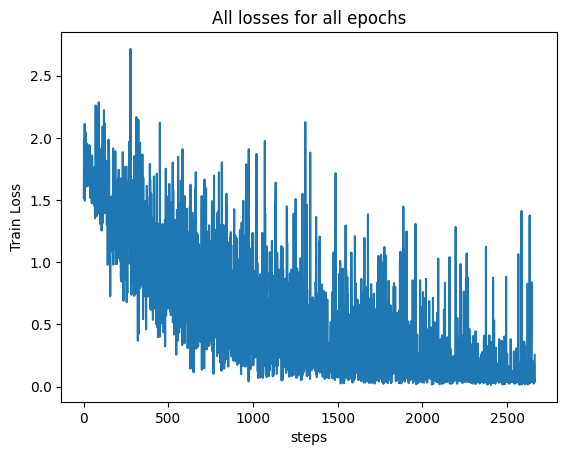

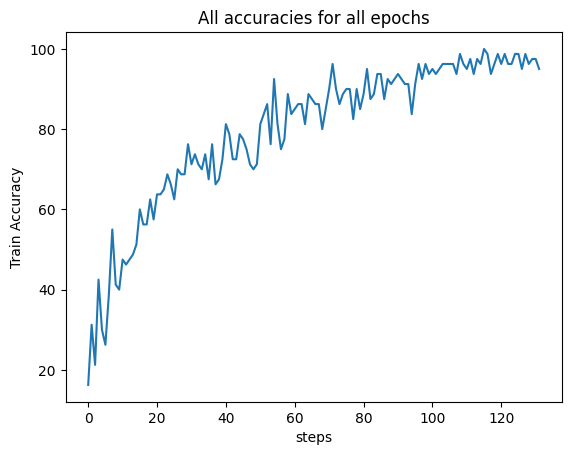

3551


In [ ]:
toc=time.time()

print("Elapsed time is",round(toc-tic,5),"seconds")

plt.plot(total_loss_for_all_epochs)
plt.title("All losses for all epochs")
plt.ylabel("Train Loss")
plt.xlabel("steps")

plt.show()

plt.plot(total_acc_for_all_epochs)
plt.title("All accuracies for all epochs")
plt.ylabel("Train Accuracy")
plt.xlabel("steps")

plt.show()

print(len(train_dataset_with_label))


In [ ]:
# #sss=bert_model(input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
# sss=bert_model(input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids,labels=label)

# print(sss.loss)

In [ ]:
bert_model.eval()
total_loss = 0.0
i = 0
total_loss=[]
total_acc=[]
total_samples= 0
total_correct= 0
for batch in test_loader:
    i += 1
    input_ids, attention_mask, token_type_ids, label, label_mask = batch
    # input_ids, attention_mask, token_type_ids, label = (
    #     input_ids.to(device),
    #     attention_mask.to(device),
    #     token_type_ids.to(device),
    #     label.to(device),
    # )

    outputs = bert_model(input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids, labels=label)
    loss = outputs.loss
    total_loss.append(loss.item())


    _, preds = torch.max(outputs[1], dim = 1)
    total_samples += label.size(0)
    total_correct += (preds == label).sum().item()


    if i%20 == 0:
      acc=100*total_correct/total_samples
      total_acc.append(acc)
      print("Step:",i,"From",len(test_dataset)//batch_size)
      print('Tes loss:',loss.item(),'Preds:',preds,"Labels:",label)
      print("Test Accuracy For 20 Steps: ",acc,"%")
      total_correct=0
      total_samples=0



Step: 20 From 750
Tes loss: 1.271405816078186 Preds: tensor([3, 5, 4, 2], device='cuda:0') Labels: tensor([0, 5, 4, 2], device='cuda:0')
Test Accuracy For 20 Steps:  56.25 %
Step: 40 From 750
Tes loss: 0.7905011177062988 Preds: tensor([0, 1, 5, 3], device='cuda:0') Labels: tensor([0, 1, 5, 1], device='cuda:0')
Test Accuracy For 20 Steps:  52.5 %
Step: 60 From 750
Tes loss: 1.6267528533935547 Preds: tensor([4, 2, 5, 0], device='cuda:0') Labels: tensor([4, 1, 0, 0], device='cuda:0')
Test Accuracy For 20 Steps:  61.25 %
Step: 80 From 750
Tes loss: 1.6043200492858887 Preds: tensor([2, 2, 4, 4], device='cuda:0') Labels: tensor([3, 2, 4, 4], device='cuda:0')
Test Accuracy For 20 Steps:  53.75 %
Step: 100 From 750
Tes loss: 0.5616500973701477 Preds: tensor([5, 3, 1, 4], device='cuda:0') Labels: tensor([5, 1, 1, 4], device='cuda:0')
Test Accuracy For 20 Steps:  56.25 %
Step: 120 From 750
Tes loss: 0.18895070254802704 Preds: tensor([3, 4, 0, 2], device='cuda:0') Labels: tensor([3, 4, 0, 2], dev

In [ ]:
average_loss =torch.mean(torch.tensor(total_loss))
average_acc =torch.mean(torch.tensor(total_acc))
print("Average Test Loss:",average_loss,"\nAverage Test Accuracy:",average_acc)

Average Test Loss: tensor(1.7907) 
Average Test Accuracy: tensor(53.7500)


# Part2 - Adapter (Bonus)

In [ ]:
#################### Adapter



class AdapterForTransformer (nn.Module):
  def __init__ (self,d,m):
    super(AdapterForTransformer, self).__init__()
    self.d=d
    self.m=m
    self.Adapter_Module=nn.Sequential(nn.Linear(self.d,self.m),
                                   nn.Tanh(),#nn.ReLU()
                                   nn.Linear(self.m,self.d)
                                   )
    self.Layer_Norm=nn.LayerNorm((d,), eps=1e-12, elementwise_affine=True)
  def forward(self,x):
    out=self.Adapter_Module(x)+x # we have skip connection in the structure of Adapter
    out=self.Layer_Norm(x)
    return out



def replace_layernorm_with_adapter(module):
    The_Layers=nn.Dropout(p=0.1)
    for name, child in module.named_children():
        #print(The_Layers)
        #s=s+1
        # print("\n\n\n\n\n")
        # print(s)
        if isinstance(child, nn.LayerNorm):
            # Replace nn.LayerNorm with AdapterForTransformer
            adapt=AdapterForTransformer(d=768, m=64)
            adapt.required_grad=True
            setattr(module, name, adapt)
            #module.add_module(module,name,adapt)
        elif isinstance(child, nn.Module):
            replace_layernorm_with_adapter(child)


bert_model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=num_class)

for param in bert_model.parameters():
    param.required_grad=False
    # print(param.required_grad)


first_layer = bert_model.bert.encoder.layer
print("Before\n\n\n\n\n")
#print(first_layer)
print(bert_model.parameters)
replace_layernorm_with_adapter(first_layer)



bert_model.bert.encoder.layer=first_layer

print("After\n\n\n\n\n")

print(bert_model.parameters)

# print(list(bert_model.children()))

# for param in list(bert_model.children()):
# for name, child in bert_model.bert.encoder.layer.named_children():
#   print(child.parameters().required_grad)
#   print("\n\n\n\n\n")



Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Before





<bound method Module.parameters of BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
        

In [ ]:
##### Chat GPT and Chat Got

#### Chat GPT

# class AdapterForTransformer(nn.Module):
#     def __init__(self, d, m):
#         super(AdapterForTransformer, self).__init__()
#         self.d = d
#         self.m = m
#         self.Adapter_Module = nn.Sequential(
#             nn.Linear(self.d, self.m),
#             nn.Tanh(),
#             nn.Linear(self.m, self.d)
#         )
#         self.Layer_Norm = nn.LayerNorm((d,), eps=1e-12, elementwise_affine=True)

#     def forward(self, x):
#         adapter_out = self.Adapter_Module(x)
#         out = adapter_out + x  # Adding skip connection
#         out = self.Layer_Norm(out)  # Corrected to apply LayerNorm to the output of the Adapter
#         return out


# def replace_layernorm_with_adapter(module):
#     The_Layers = nn.Dropout(p=0.1)
#     for name, child in module.named_children():
#         if isinstance(child, nn.LayerNorm):
#             # Replace nn.LayerNorm with AdapterForTransformer
#             adapt = AdapterForTransformer(d=768, m=64)
#             adapt.requires_grad = True  # Corrected to set requires_grad attribute
#             setattr(module, name, adapt)
#         elif isinstance(child, nn.Module):
#             replace_layernorm_with_adapter(child)


# # Assuming num_class is defined somewhere in your code
# num_class = 6

# # Create a BERT model
# bert_model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=num_class)

# # for param in bert_model.parameters():
# #     param.requires_grad=False

# # Access the first layer of the BERT model
# first_layer = bert_model.bert.encoder.layer

# print("Before Replacement:")
# print(bert_model)

# # Replace LayerNorm with AdapterForTransformer
# replace_layernorm_with_adapter(first_layer)

# print("\nAfter Replacement:")
# print(bert_model)



######## ChatGot

# import torch
# import torch.nn as nn
# from transformers import BertForSequenceClassification

# class AdapterForTransformer(nn.Module):
#     def __init__(self, d, m):
#         super(AdapterForTransformer, self).__init__()
#         self.adapter_module = nn.Sequential(
#             nn.Linear(d, m),
#             nn.Tanh(),  # You can experiment with different activations, like ReLU
#             nn.Linear(m, d)
#         )
#         self.layer_norm = nn.LayerNorm(d, eps=1e-12, elementwise_affine=True)

#     def forward(self, x):
#         # Ensure the skip connection adds the adapter's output rather than the input x
#         out = self.adapter_module(x) + x
#         out = self.layer_norm(out)  # Apply LayerNorm to the combined output
#         return out

# def replace_layernorm_with_adapter(module, d=768, m=64):
#     for name, child in module.named_children():
#         if isinstance(child, nn.LayerNorm):
#             # Create the adapter module with gradients enabled
#             adapter = AdapterForTransformer(d, m)
#             for param in adapter.parameters():
#                 param.requires_grad = True
#             setattr(module, name, adapter)
#         else:
#             # Recursively apply this function to all child modules
#             replace_layernorm_with_adapter(child, d, m)

# num_class = 6# Remember to set your number of classes here
# bert_model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=num_class)

# for param in bert_model.parameters():
#     param.requires_grad=False

# # Print the model structure before modifications
# print("Before replacement:")
# print(bert_model)

# # Replace all LayerNorm layers with AdapterForTransformer
# replace_layernorm_with_adapter(bert_model)

# # Print the model structure after modifications
# print("\nAfter replacement:")
# print(bert_model)


####### Chat GPT After Chat Got

import torch
import torch.nn as nn
from transformers import BertForSequenceClassification

class AdapterForTransformer(nn.Module):
    def __init__(self, d, m):
        super(AdapterForTransformer, self).__init__()
        self.adapter_module = nn.Sequential(
            nn.Linear(d, m),
            nn.Tanh(),  # You can experiment with different activations, like ReLU
            nn.Linear(m, d)
        )
        self.layer_norm = nn.LayerNorm(d, eps=1e-12, elementwise_affine=True)

    def forward(self, x):
        # Ensure the skip connection adds the adapter's output rather than the input x
        out = self.adapter_module(x) + x
        out = self.layer_norm(out)  # Apply LayerNorm to the combined output
        return out

def replace_layernorm_with_adapter(module, d=768, m=64):
    for name, child in module.named_children():
        if isinstance(child, nn.LayerNorm):
            # Create the adapter module with gradients enabled
            adapter = AdapterForTransformer(d, m)
            torch.set_grad_enabled(True)  # Enable gradients for the adapter module
            setattr(module, name, adapter)
        else:
            # Recursively apply this function to all child modules
            replace_layernorm_with_adapter(child, d, m)

num_class = 6  # Remember to set your number of classes here
bert_model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=num_class)

for param in bert_model.parameters():
    param.requires_grad = False

# Print the model structure before modifications
print("Before replacement:")
print(bert_model)

# Replace all LayerNorm layers with AdapterForTransformer
replace_layernorm_with_adapter(bert_model)

# Print the model structure after modifications
print("\nAfter replacement:")
print(bert_model)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Before replacement:
BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNor

In [ ]:
# ############ Copy of Upper program:


# #################### Adapter



# class AdapterForTransformer (nn.Module):
#   def __init__ (self,d,m):
#     super(AdapterForTransformer, self).__init__()
#     self.d=d
#     self.m=m
#     self.Adapter_Module=nn.Sequential(nn.Linear(self.d,self.m),
#                                    nn.Tanh(),#nn.ReLU()
#                                    nn.Linear(self.m,self.d)
#                                    )
#     self.Layer_Norm=nn.LayerNorm((d,), eps=1e-12, elementwise_affine=True)
#   def forward(self,x):
#     out=self.Adapter_Module(x)+x # we have skip connection in the structure of Adapter
#     out=self.Layer_Norm(x)
#     return out


# def replace_layernorm_with_adapter(module):
#     for name, child in module.named_children():
#       The_Layers=child
#       break
#     s=0

#     print(The_Layers)
#     for name, child in module.named_children():
#         s=s+1
#         # if(s>2):
#         #   print("salam")
#         #   The_Layers=nn.Sequential(The_Layers,child)

#         # if isinstance(child, nn.LayerNorm):
#         #     # Replace nn.LayerNorm with AdapterForTransformer
#         #     adapt=AdapterForTransformer(d=762, m=64)
#         #     adapt.required_grad=True
#         #     setattr(module, name, adapt)
#             #module.add_module(module,name,adapt)
#         # elif isinstance(child, nn.Module):
#         #     replace_layernorm_with_adapter(child)


#     print("S is:",s)
#     return The_Layers

# bert_model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=num_class)

# for param in bert_model.parameters():
#     param.required_grad=False
#     # print(param.required_grad)


# first_layer = bert_model.bert.encoder.layer
# # print("Before\n\n\n\n\n")
# # #print(first_layer)
# # print(bert_model.parameters)
# replace_layernorm_with_adapter(first_layer)



# # bert_model.bert.encoder.layer=The_Layers

# # print("After\n\n\n\n\n")

# # print(bert_model.parameters)

# # print(list(bert_model.children()))

# # for param in list(bert_model.children()):

# # for name, child in bert_model.bert.encoder.layer.named_children():
# #   print(child.parameters().required_grad)
# #   print("\n\n\n\n\n")


In [ ]:

# adapt=AdapterForTransformer(d=762, m=64)
# adapt.required_grad=True


# # Load the pre-trained BERT model
# bert_model = BertForSequenceClassification .from_pretrained('bert-base-uncased', num_labels=6)

# # Access the internal components of the BERT model
# bert_layers = list(bert_model.children())


# # print(bert_layers)

# # print("\n\n\n\n\n")


# # print(bert_model.parameters)

# # Find the index of the nn.LayerNorm layer (assuming it's the last layer in the BERT model)
# layer_norm_index = -1



# s=0
# for i, layer in enumerate(bert_layers):
#     print("\n\n\n\n")
#     print(layer)
#     #bert_layers = list(layer.children())
#     ff_model=nn.Sequential(layer)
#     s=s+1

#     bert_layers2 = list(ff_model.children())

#     for j, layer2 in enumerate(bert_layers2):

#       print(layer2)
#       print("salam")
#       if isinstance(layer2, adapt):
#           layer_norm_index = i
#           break


#     break# Because all the nn.LayerNorms are in the first layer !!

# print(s)
# # # Check if nn.LayerNorm was found
# # if layer_norm_index == -1:
# #     raise ValueError("Could not find nn.LayerNorm in the BERT model.")

# # # Create a new nn.Linear layer with appropriate input and output sizes
# # linear_layer = nn.Linear(in_features=bert_model.config.hidden_size, out_features=512)

# # # Insert the new nn.Linear layer after nn.LayerNorm
# # new_bert_layers = bert_layers[:layer_norm_index + 1] + [linear_layer] + bert_layers[layer_norm_index + 1:]

# # # Create a new BERT model with the modified architecture
# # new_bert_model = nn.Sequential(*new_bert_layers)

# # # Now you can use new_bert_model for further training or inference


# # # print(new_bert_model.parameters())


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Parameter containing:
tensor([[-0.0102, -0.0615, -0.0265,  ..., -0.0199, -0.0372, -0.0098],
        [-0.0117, -0.0600, -0.0323,  ..., -0.0168, -0.0401, -0.0107],
        [-0.0198, -0.0627, -0.0326,  ..., -0.0165, -0.0420, -0.0032],
        ...,
        [-0.0218, -0.0556, -0.0135,  ..., -0.0043, -0.0151, -0.0249],
        [-0.0462, -0.0565, -0.0019,  ...,  0.0157, -0.0139, -0.0095],
        [ 0.0015, -0.0821, -0.0160,  ..., -0.0081, -0.0475,  0.0753]],
       requires_grad=True)
1


In [ ]:
######### NEW BERT MODEL , We Have Adapter This Time!!!

bert_model=to_device(bert_model,device)

# Define hyperparameters
learning_rate = 2e-5
epochs = 3

# bert_model2=BERT_ARCH2(num_class)
optimizer = torch.optim.AdamW(bert_model.parameters(), lr=learning_rate)
loss_fn = torch.nn.CrossEntropyLoss()

total_steps = len(train_loader_with_label) * epochs

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)


# bert_model2=to_device(bert_model2,device)
total_loss_for_all_epochs=[]
total_acc_for_all_epochs=[]
# Training loop
tic=time.time()
for epoch in range(epochs):
    bert_model.train()
    total_loss=[]
    total_acc=[]
    total_samples= 0
    total_correct= 0
    i=0
    for batch in train_loader_with_label:
        i=i+1
        input_ids, attention_mask, token_type_ids, label,mask_label = batch
        # input_ids, attention_mask, token_type_ids, label = (
        #     input_ids.to(device),
        #     attention_mask.to(device),
        #     token_type_ids.to(device),
        #     label.to(device),
        # )

        optimizer.zero_grad()

        if (label is None):
           print("salam")
           #outputs = bert_model(input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids, labels=input_ids)
           outputs = bert_model(input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
           #outputs = bert_model(input_ids, attention_mask=attention_mask)
        else:
           print("salam2")
           #outputs = bert_model(input_ids, attention_mask=attention_mask)
           outputs = bert_model(input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids, labels=label)


        #loss=loss_fn(outputs.logits,label)
        loss = outputs.loss



        total_loss.append(loss.item())
        total_loss_for_all_epochs.append(loss.item())
        loss.backward()
        optimizer.step()
        scheduler.step()
        print("Step:",i,"  From",len(train_dataset_with_label)//batch_size, "  Loss:",loss.item())
        _, preds = torch.max(outputs[1], dim = 1)
        total_samples += label.size(0)
        total_correct += (preds == label).sum().item()


        if i%20 == 0:
          acc_train=100*total_correct/total_samples

          print("Train Accuracy For 20 Steps: ",acc_train,"%")
          total_correct=0
          total_samples=0
          total_acc.append(acc_train)
          total_acc_for_all_epochs.append(acc_train)

    print(f"Epoch {epoch + 1}/{epochs}")
    print("Average Train Loss:", torch.mean(torch.tensor(total_loss)),"Average Train Accuracy:", torch.mean(torch.tensor(total_acc)))




salam2
Step: 1   From 887   Loss: 1.6194424629211426
salam2
Step: 2   From 887   Loss: 1.8257635831832886
salam2
Step: 3   From 887   Loss: 2.0571844577789307
salam2
Step: 4   From 887   Loss: 1.8546350002288818
salam2
Step: 5   From 887   Loss: 1.7526988983154297
salam2
Step: 6   From 887   Loss: 1.917659044265747
salam2
Step: 7   From 887   Loss: 1.8792085647583008
salam2
Step: 8   From 887   Loss: 1.8337042331695557
salam2
Step: 9   From 887   Loss: 2.069267511367798
salam2
Step: 10   From 887   Loss: 1.9506468772888184
salam2
Step: 11   From 887   Loss: 2.0189971923828125
salam2
Step: 12   From 887   Loss: 1.7418785095214844
salam2
Step: 13   From 887   Loss: 1.7678074836730957
salam2
Step: 14   From 887   Loss: 1.9346097707748413
salam2
Step: 15   From 887   Loss: 1.8316899538040161
salam2
Step: 16   From 887   Loss: 1.592766284942627
salam2
Step: 17   From 887   Loss: 1.7677110433578491
salam2
Step: 18   From 887   Loss: 1.7710514068603516
salam2
Step: 19   From 887   Loss: 1.765

KeyboardInterrupt: 

Elapsed time is 137.03707 seconds


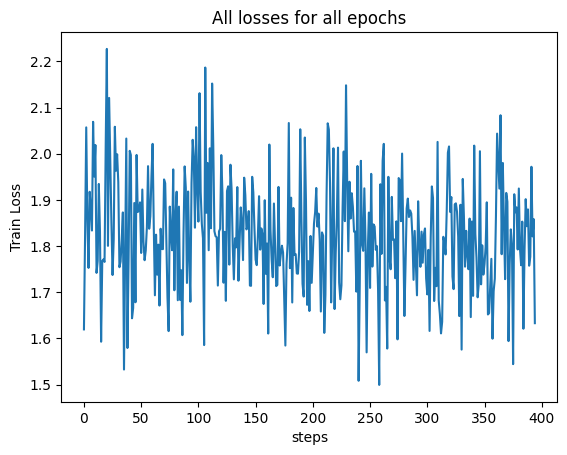

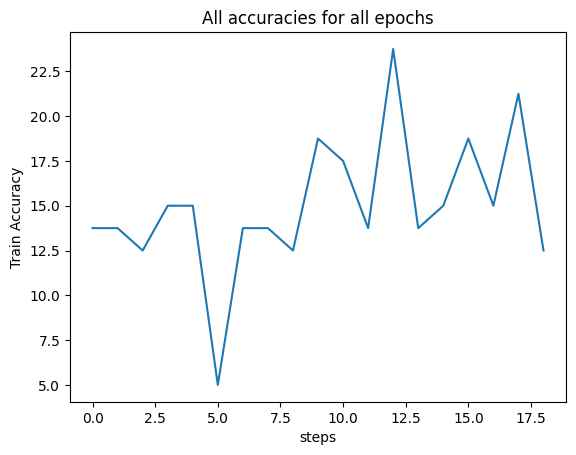

3551


In [ ]:
toc=time.time()

print("Elapsed time is",round(toc-tic,5),"seconds")
plt.plot(total_loss_for_all_epochs)
plt.title("All losses for all epochs")
plt.ylabel("Train Loss")
plt.xlabel("steps")

plt.show()

plt.plot(total_acc_for_all_epochs)
plt.title("All accuracies for all epochs")
plt.ylabel("Train Accuracy")
plt.xlabel("steps")

plt.show()

print(len(train_dataset_with_label))


In [ ]:
bert_model.eval()
total_loss = 0.0
i = 0
total_loss=[]
total_acc=[]
total_samples= 0
total_correct= 0
for batch in test_loader:
    i += 1
    input_ids, attention_mask, token_type_ids, label,mask_label = batch
    # input_ids, attention_mask, token_type_ids, label = (
    #     input_ids.to(device),
    #     attention_mask.to(device),
    #     token_type_ids.to(device),
    #     label.to(device),
    # )

    outputs = bert_model(input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids, labels=label)
    loss = outputs.loss
    total_loss.append(loss.item())


    _, preds = torch.max(outputs[1], dim = 1)
    total_samples += label.size(0)
    total_correct += (preds == label).sum().item()


    if i%20 == 0:
      acc=100*total_correct/total_samples
      total_acc.append(acc)
      print("Step:",i,"From",len(test_dataset)//batch_size)
      print('Tes loss:',loss.item(),'Preds:',preds,"Labels:",label)
      print("Test Accuracy For 20 Steps: ",acc,"%")
      total_correct=0
      total_samples=0



Step: 20 From 750
Tes loss: 1.7793554067611694 Preds: tensor([2, 2, 2, 2], device='cuda:0') Labels: tensor([2, 1, 4, 3], device='cuda:0')
Test Accuracy For 20 Steps:  7.5 %
Step: 40 From 750
Tes loss: 1.713021993637085 Preds: tensor([2, 2, 2, 2], device='cuda:0') Labels: tensor([2, 4, 0, 4], device='cuda:0')
Test Accuracy For 20 Steps:  17.5 %
Step: 60 From 750
Tes loss: 1.9876757860183716 Preds: tensor([2, 2, 2, 2], device='cuda:0') Labels: tensor([3, 3, 0, 3], device='cuda:0')
Test Accuracy For 20 Steps:  20.0 %
Step: 80 From 750
Tes loss: 1.712104082107544 Preds: tensor([2, 2, 2, 2], device='cuda:0') Labels: tensor([5, 2, 5, 2], device='cuda:0')
Test Accuracy For 20 Steps:  18.75 %
Step: 100 From 750
Tes loss: 1.7239233255386353 Preds: tensor([2, 2, 2, 2], device='cuda:0') Labels: tensor([0, 4, 2, 4], device='cuda:0')
Test Accuracy For 20 Steps:  23.75 %
Step: 120 From 750
Tes loss: 1.816349744796753 Preds: tensor([2, 2, 2, 2], device='cuda:0') Labels: tensor([5, 3, 2, 0], device='c

KeyboardInterrupt: 

In [ ]:
average_loss =torch.mean(torch.tensor(total_loss))
average_acc =torch.mean(torch.tensor(total_acc))
print("Average Test Loss:",average_loss,"\nAverage Test Accuracy:",average_acc)


# Part3 - GAN-BERT

In [ ]:
################ GAN_BERT


############### Dataset for GAN_BERT

# train_dataset_without_label = BERT_Dataset(text = all_texts_shuffled[int(percentage*len(all_texts_shuffled)):],
#                              labels = all_labels_shuffled[int(percentage*len(all_texts_shuffled)):],
#                              max_len = max_len)


train_dataset_without_label = BERT_Dataset(text = all_texts_shuffled[int(percentage*len(all_texts_shuffled)):],
                             labels = all_labels_shuffled[int(percentage*len(all_texts_shuffled)):],
                             label_masks=all_labels_masks[int(percentage*len(all_texts_shuffled)):],
                             max_len = len(all_labels)-max_len)

used_train_dataset_without_label,non_used_train_dataset_without_label=torch.utils.data.random_split(train_dataset_without_label,[int(0.01*len(train_dataset_without_label)), len(train_dataset_without_label)-int(0.01*len(train_dataset_without_label))])


train_dataset = torch.utils.data.ConcatDataset([used_train_dataset_without_label, train_dataset_with_label])

#train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle = False)
train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)


train_loader = DeviceDataLoader(train_loader, device)

print(len(used_train_dataset_without_label))

print(len(train_dataset_with_label))


674
3551


In [ ]:
len(train_dataset)
# label_masks=all_labels_masks[int(percentage*len(all_texts_shuffled)):]
# print(label_masks)
# print(torch.sum(all_labels_masks))
print(len(train_dataset))
print(len(train_dataset_without_label))
print(len(train_dataset_with_label))
for i in range(500):
  index=np.random.randint(len(train_dataset))
  print(train_dataset[index][3:])

print(train_dataset_without_label[0])

4225
67476
3551
(4, tensor(True, device='cuda:0'))
(1, tensor(False, device='cuda:0'))
(2, tensor(True, device='cuda:0'))
(2, tensor(False, device='cuda:0'))
(1, tensor(True, device='cuda:0'))
(0, tensor(True, device='cuda:0'))
(4, tensor(False, device='cuda:0'))
(5, tensor(True, device='cuda:0'))
(5, tensor(False, device='cuda:0'))
(0, tensor(True, device='cuda:0'))
(2, tensor(True, device='cuda:0'))
(4, tensor(False, device='cuda:0'))
(3, tensor(True, device='cuda:0'))
(4, tensor(True, device='cuda:0'))
(5, tensor(True, device='cuda:0'))
(1, tensor(True, device='cuda:0'))
(1, tensor(True, device='cuda:0'))
(0, tensor(True, device='cuda:0'))
(5, tensor(True, device='cuda:0'))
(4, tensor(True, device='cuda:0'))
(0, tensor(False, device='cuda:0'))
(3, tensor(True, device='cuda:0'))
(4, tensor(True, device='cuda:0'))
(0, tensor(True, device='cuda:0'))
(4, tensor(True, device='cuda:0'))
(2, tensor(True, device='cuda:0'))
(1, tensor(True, device='cuda:0'))
(0, tensor(True, device='cuda:0')

In [ ]:
################## Generator and Discriminator and bert model again!



class Generator(nn.Module):
    def __init__(self, noise_dim,hidden_layers, output_layer):
        super(Generator, self).__init__()

        self.Generator_Network=nn.Sequential(nn.Linear(noise_dim,hidden_layers[0]),
                                             nn.LeakyReLU(0.2),
                                             nn.Dropout(p=0.1),


                                             nn.Linear(hidden_layers[0],output_layer)
        )

    def forward(self,x):
        output= self.Generator_Network(x)
        return output


class Discriminator(nn.Module):
    def __init__(self,input_dim,hidden_layers, output_layer):

        super(Discriminator, self).__init__()
        self.Discriminator_Features=nn.Sequential( nn.Dropout(p=0.1),
                                                   nn.Linear(input_dim,hidden_layers[0]),
                                                   nn.LeakyReLU(0.2),
                                                   nn.Dropout(p=0.1),

        )




        self.last_linear = nn.Linear(hidden_layers[0],output_layer)

        # self.softmax = nn.Softmax(dim=-1)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):

        features = self.Discriminator_Features(x)
        last_linear_val = self.last_linear(features)
        output = self.softmax(last_linear_val)

        return features, last_linear_val, output



# class Generator(nn.Module):
#     def __init__(self, noise_dim,hidden_layers, output_layer):
#         super(Generator, self).__init__()

#         self.Generator_Network=nn.Sequential(nn.Linear(noise_dim,hidden_layers[0]),
#                                              nn.LeakyReLU(0.2),
#                                              nn.Dropout(p=0.1),
#                                              nn.Linear(hidden_layers[0],hidden_layers[1]),
#                                              nn.LeakyReLU(0.2),
#                                              nn.Dropout(p=0.1),
#                                              nn.Linear(hidden_layers[1],hidden_layers[2]),
#                                              nn.LeakyReLU(0.2),
#                                              nn.Dropout(p=0.1),
#                                              nn.Linear(hidden_layers[2],hidden_layers[3]),
#                                              nn.LeakyReLU(0.2),
#                                              nn.Dropout(p=0.1),

#                                              nn.Linear(hidden_layers[3],output_layer)
#         )

#     def forward(self,x):
#         output= self.Generator_Network(x)
#         return output


# class Discriminator(nn.Module):
#     def __init__(self,input_dim,hidden_layers, output_layer):

#         super(Discriminator, self).__init__()
#         self.Discriminator_Features=nn.Sequential( nn.Dropout(p=0.1),
#                                                    nn.Linear(input_dim,hidden_layers[0]),
#                                                    nn.LeakyReLU(0.2),
#                                                    nn.Dropout(p=0.1),
#                                                    nn.Linear(hidden_layers[0],hidden_layers[1]),
#                                                    nn.LeakyReLU(0.2),
#                                                    nn.Dropout(p=0.1),
#                                                    nn.Linear(hidden_layers[1],hidden_layers[2]),
#                                                    nn.LeakyReLU(0.2),
#                                                    nn.Dropout(p=0.1),
#                                                    nn.Linear(hidden_layers[2],hidden_layers[3]),
#                                                    nn.LeakyReLU(0.2),
#                                                    nn.Dropout(p=0.1),

#         )




#         self.last_linear = nn.Linear(hidden_layers[3],output_layer)

#         self.softmax = nn.Softmax(dim=-1)

#     def forward(self, x):

#         features = self.Discriminator_Features(x)
#         last_linear_val = self.last_linear(features)
#         output = self.softmax(last_linear_val)

#         return features, last_linear_val, output




# The output of this bert should be 768D
# bert_model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=768)
bert_model = AutoModel.from_pretrained('bert-base-uncased')

In [ ]:
bert_model.parameters

<bound method Module.parameters of BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout

In [ ]:



# config = AutoConfig.from_pretrained(model_name)
# hidden_size = int(config.hidden_size)
# Define the number and width of hidden layers
# hidden_levels_g = [hidden_size for i in range(0, num_hidden_layers_g)]
# hidden_levels_d = [hidden_size for i in range(0, num_hidden_layers_d)]
hidden_size=512
hidden_layers_generator=[hidden_size,hidden_size//2,hidden_size//2,hidden_size]
hidden_levels_discriminator=[hidden_size,hidden_size//2,hidden_size//2,hidden_size]

# hidden_size=512
# hidden_layers_generator=[hidden_size]
# hidden_levels_discriminator=[hidden_size]


noise_dim=100
output_layer=768
generator_network = Generator(noise_dim=noise_dim, hidden_layers=hidden_layers_generator, output_layer=output_layer)

# We know that discriminator has a K+1 architecture because of its tasks which include detecting real and fake, and detecting the class
discriminator_network = Discriminator(input_dim=output_layer, hidden_layers=hidden_levels_discriminator,output_layer=len(np.unique(all_labels))+1)

generator_network=to_device(generator_network,device)
discriminator_network=to_device(discriminator_network,device)
bert_model=to_device(bert_model,device)

print(generator_network)
print("\n\n\n\n")
print(discriminator_network)


Generator(
  (Generator_Network): Sequential(
    (0): Linear(in_features=100, out_features=512, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=512, out_features=768, bias=True)
  )
)





Discriminator(
  (Discriminator_Features): Sequential(
    (0): Dropout(p=0.1, inplace=False)
    (1): Linear(in_features=768, out_features=512, bias=True)
    (2): LeakyReLU(negative_slope=0.2)
    (3): Dropout(p=0.1, inplace=False)
  )
  (last_linear): Linear(in_features=512, out_features=7, bias=True)
  (softmax): Softmax(dim=1)
)


In [ ]:
# import torch.nn.functional as F
# tic = time.time()

# #models parameters
# #⛔️
# bert_model_vars = [i for i in bert_model.parameters()]
# d_vars = bert_model_vars + [v for v in discriminator_network.parameters()]
# g_vars = [v for v in generator_network.parameters()]

# learning_rate_discriminator = 5e-5
# learning_rate_generator = 5e-5


# dicriminator_optimizer = torch.optim.AdamW(d_vars, lr=learning_rate_discriminator)
# generator_optimizer = torch.optim.AdamW(g_vars, lr=learning_rate_generator)
# #⛔️



# #⛔️
# # learning_rate_discriminator = 5e-5
# # learning_rate_generator = 5e-5

# # dicriminator_optimizer = torch.optim.AdamW(discriminator_network.parameters(), lr=learning_rate_discriminator)
# # generator_optimizer = torch.optim.AdamW(generator_network.parameters(), lr=learning_rate_generator)
# #⛔️


# # num_train_examples = len(train_examples)
# # num_train_steps = int(num_train_examples / batch_size * num_train_epochs)
# # num_warmup_steps = int(num_train_steps * warmup_proportion)

# num_warmup_steps = 0 # It was for our program! 0 !


# # scheduler_d = get_constant_schedule_with_warmup(dis_optimizer,
# #                                           num_warmup_steps = num_warmup_steps)
# # scheduler_g = get_constant_schedule_with_warmup(gen_optimizer,
# #                                           num_warmup_steps = num_warmup_steps)

# total_steps = len(train_dataset) * epochs

# scheduler_discriminator = get_linear_schedule_with_warmup(
#   dicriminator_optimizer,
#   num_warmup_steps=0,
#   num_training_steps=total_steps
# )

# scheduler_generator = get_linear_schedule_with_warmup(
#   dicriminator_optimizer,
#   num_warmup_steps=0,
#   num_training_steps=total_steps
# )


# generator_train_loss_for_all_epochs=[]
# discriminator_train_loss_for_all_epochs=[]
# total_acc_for_all_epochs=[]

# epsilon = 1e-8

# all_preds=[]
# for epoch in range(epochs):

#     generator_train_loss=[]
#     discriminator_train_loss=[]

#     bert_model.train()
#     generator_network.train()
#     discriminator_network.train()
#     total_samples = 0
#     total_correct = 0
#     total_acc=[]
#     i=0

#     for batch in train_loader:
#         input_ids, attention_mask, token_type_ids, label, mask = batch
#         i=i+1


#         batch_size = len(input_ids)
#         # print(mask)
#         # if (all(mask)==True):
#           # print("\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nAll are True, so we go for supervised learning!")
#           # output_bert = bert_model(input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids, labels=label)
#           # bert_loss=output_bert.loss
#           # bert_loss.backward()


#         # else:
#         #   #print("Not all are True, so we go for unsupervised learning!")
#         #   output_bert = bert_model(input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)


#         output_bert = bert_model(input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)


#         features_bert = torch.squeeze(output_bert[0][:,-1,:])

#         #print(features_bert.shape)

#         noise = torch.randn(batch_size,noise_dim).to(device)


#         output_generator = generator_network(noise)


#         input_discriminator = torch.cat([features_bert, output_generator], dim=0)
#         # Then, we select the output of the disciminator
#         features_discriminator, last_linear_discriminator, output_discriminator = discriminator_network(input_discriminator)

#         # print("output_discriminator")
#         # print(output_discriminator.shape)
#         # print("\n\nlast_linear_discriminator")
#         # print(last_linear_discriminator.shape)




#         # Finally, we separate the discriminator's output for the real and fake
#         # data
#         #⛔️
#         features_list = torch.split(features_discriminator, batch_size)
#         D_real_features = features_list[0]
#         D_fake_features = features_list[1]

#         logits_list = torch.split(last_linear_discriminator, batch_size)
#         D_real_logits = logits_list[0]
#         D_fake_logits = logits_list[1]

#         probs_list = torch.split(output_discriminator, batch_size)
#         D_real_probs = probs_list[0]
#         D_fake_probs = probs_list[1]
#         #⛔️
#         #---------------------------------
#         #  LOSS evaluation
#         #---------------------------------
#         # Generator's LOSS estimation
#         g_loss_d = -1 * torch.mean(torch.log(1 - D_fake_probs[:,-1] + epsilon))
#         generator_loss_feature_matching = torch.mean(torch.pow(torch.mean(D_real_features, dim=0) - torch.mean(D_fake_features, dim=0), 2))
#         All_generator_losses = g_loss_d + generator_loss_feature_matching

#         # Disciminator's LOSS estimation
#         logits = D_real_logits[:,0:-1]
#         log_probs = F.log_softmax(logits, dim=-1)

#         ###### plan 1
#         label2one_hot = torch.nn.functional.one_hot(label, len(np.unique(all_labels)))
#         per_example_loss = -torch.sum(label2one_hot * log_probs, dim=-1)
#         log_probs_masked = torch.masked_select(per_example_loss, mask)

#         masked_labelsss = torch.masked_select(label, mask)
#         #D_L_Supervised=F.cross_entropy(log_probs_masked,masked_labelsss)

#         D_L_Supervised=F.cross_entropy(log_probs_masked.to(torch.float32),masked_labelsss.to(torch.float32))

#         ###### plan 2
#         # # The discriminator provides an output for labeled and unlabeled real data
#         # # so the loss evaluated for unlabeled data is ignored (masked)
#         # label2one_hot = torch.nn.functional.one_hot(label, len(np.unique(all_labels)))
#         # per_example_loss = -torch.sum(label2one_hot * log_probs, dim=-1)
#         # per_example_loss = torch.masked_select(per_example_loss, mask)
#         # labeled_example_count = per_example_loss.type(torch.float32).numel()

#         # # It may be the case that a batch does not contain labeled examples,
#         # # so the "supervised loss" in this case is not evaluated
#         # if labeled_example_count == 0:
#         #   D_L_Supervised = 0
#         # else:
#         #   D_L_Supervised = torch.div(torch.sum(per_example_loss.to(device)), labeled_example_count)

#         D_L_unsupervised1U = -1 * torch.mean(torch.log(1 - D_real_probs[:, -1] + epsilon))
#         D_L_unsupervised2U = -1 * torch.mean(torch.log(D_fake_probs[:, -1] + epsilon))
#         All_discriminator_losses = D_L_Supervised + D_L_unsupervised1U + D_L_unsupervised2U


#         generator_optimizer.zero_grad()
#         dicriminator_optimizer.zero_grad()
#         #⛔️
#         All_generator_losses.backward(retain_graph=True)

#         #All_generator_losses.backward()
#         #⛔️
#         All_discriminator_losses.backward()

#         #All_generator_losses+All_discriminator_losses.backward(retain_graph=True)

#         generator_train_loss.append(All_generator_losses.item())
#         discriminator_train_loss.append(All_discriminator_losses.item())

#         generator_train_loss_for_all_epochs.append(All_generator_losses.item())
#         discriminator_train_loss_for_all_epochs.append(All_discriminator_losses.item())

#         generator_optimizer.step()
#         dicriminator_optimizer.step()
#         scheduler_generator.step()
#         scheduler_discriminator.step()



#         ## Determining the predicted labels:
#         D_real_probs
#         _, preds = torch.max(D_real_probs, dim = 1)
#         total_samples += label.size(0)
#         total_correct += (preds == label).sum().item()
#         all_preds.append(preds)
#         if i%5 == 0:
#           acc=100*total_correct/total_samples
#           total_acc.append(acc)
#           total_acc_for_all_epochs.append(acc)
#           print("Step:",i,"From",len(train_dataset)//batch_size)
#           print('Preds:',preds,"Labels:",label)
#           print("Test Accuracy For 20 Steps: ",acc,"%")
#           print("\n","Generator's loss: ", All_generator_losses.item(),"Discriminator's loss: ", All_discriminator_losses.item())

#           total_correct=0
#           total_samples=0



#     print("Epoch:",epoch,"\n","Average generator's loss in an epoch: ", torch.mean(generator_train_loss),"Average discriminator's loss in an epoch: ", torch.mean(discriminator_train_loss))


#     # #bert_model.eval() #maybe redundant
#     # discriminator_network.eval()
#     # generator_network.eval()

#     # # Tracking variables
#     # total_test_accuracy = 0

#     # total_test_loss = 0
#     # nb_test_steps = 0

#     # all_preds = []
#     # all_labels_ids = []

#     # #loss
#     # nll_loss = torch.nn.CrossEntropyLoss(ignore_index=-1)

#     # # Evaluate data for one epoch
#     # for batch in test_loader:

#     #     # Unpack this training batch from our dataloader.
#     #     b_input_ids = batch[0].to(device)
#     #     b_input_mask = batch[1].to(device)
#     #     b_labels = batch[2].to(device)

#     #     # Tell pytorch not to bother with constructing the compute graph during
#     #     # the forward pass, since this is only needed for backprop (training).
#     #     with torch.no_grad():
#     #         model_outputs = bert_model(b_input_ids, attention_mask=b_input_mask)
#     #         hidden_states = model_outputs[-1]
#     #         _, logits, probs = discriminator_network(hidden_states)
#     #         ###log_probs = F.log_softmax(probs[:,1:], dim=-1)
#     #         filtered_logits = logits[:,0:-1]
#     #         # Accumulate the test loss.
#     #         total_test_loss += nll_loss(filtered_logits, b_labels)

#     #     # Accumulate the predictions and the input labels
#     #     _, preds = torch.max(filtered_logits, 1)
#     #     all_preds += preds.detach().cpu()
#     #     all_labels_ids += b_labels.detach().cpu()

#     # # Report the final accuracy for this validation run.
#     # all_preds = torch.stack(all_preds).numpy()
#     # all_labels_ids = torch.stack(all_labels_ids).numpy()
#     # test_accuracy = np.sum(all_preds == all_labels_ids) / len(all_preds)

#     # # Calculate the average loss over all of the batches.
#     # avg_test_loss = total_test_loss / len(test_loader)
#     # avg_test_loss = avg_test_loss.item()


Step: 5 From 17756
Preds: tensor([1, 1, 1, 1], device='cuda:0') Labels: tensor([1, 0, 3, 5], device='cuda:0')
Test Accuracy For 20 Steps:  15.0 %

 Generator's loss:  0.5048050284385681 Discriminator's loss:  7.456050872802734
Step: 10 From 17756
Preds: tensor([1, 1, 1, 1], device='cuda:0') Labels: tensor([2, 1, 4, 2], device='cuda:0')
Test Accuracy For 20 Steps:  15.0 %

 Generator's loss:  0.41741931438446045 Discriminator's loss:  13.922245025634766
Step: 15 From 17756
Preds: tensor([1, 1, 1, 1], device='cuda:0') Labels: tensor([0, 4, 2, 5], device='cuda:0')
Test Accuracy For 20 Steps:  5.0 %

 Generator's loss:  0.7533423900604248 Discriminator's loss:  1.88416588306427
Step: 20 From 17756
Preds: tensor([1, 1, 1, 1], device='cuda:0') Labels: tensor([4, 0, 1, 2], device='cuda:0')
Test Accuracy For 20 Steps:  10.0 %

 Generator's loss:  0.507273256778717 Discriminator's loss:  6.529730796813965
Step: 25 From 17756
Preds: tensor([1, 1, 1, 1], device='cuda:0') Labels: tensor([0, 2, 0, 

KeyboardInterrupt: 

In [ ]:
#################### COPY OF UPPER PROGRAM ( Does not contain cross entropy loss!)



import torch.nn.functional as F
tic = time.time()
epochs = 3

#models parameters
#⛔️
bert_model_vars = [i for i in bert_model.parameters()]
d_vars = bert_model_vars + [v for v in discriminator_network.parameters()]
g_vars = [v for v in generator_network.parameters()]

learning_rate_discriminator = 5e-5
learning_rate_generator = 5e-5


dicriminator_optimizer = torch.optim.AdamW(d_vars, lr=learning_rate_discriminator)
generator_optimizer = torch.optim.AdamW(g_vars, lr=learning_rate_generator)
#⛔️



#⛔️
# learning_rate_discriminator = 5e-5
# learning_rate_generator = 5e-5

# dicriminator_optimizer = torch.optim.AdamW(discriminator_network.parameters(), lr=learning_rate_discriminator)
# generator_optimizer = torch.optim.AdamW(generator_network.parameters(), lr=learning_rate_generator)
#⛔️


# num_train_examples = len(train_examples)
# num_train_steps = int(num_train_examples / batch_size * num_train_epochs)
# num_warmup_steps = int(num_train_steps * warmup_proportion)

num_warmup_steps = 0 # It was for our program! 0 !


# scheduler_d = get_constant_schedule_with_warmup(dis_optimizer,
#                                           num_warmup_steps = num_warmup_steps)
# scheduler_g = get_constant_schedule_with_warmup(gen_optimizer,
#                                           num_warmup_steps = num_warmup_steps)

total_steps = len(train_dataset) * epochs

scheduler_discriminator = get_linear_schedule_with_warmup(
  dicriminator_optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

scheduler_generator = get_linear_schedule_with_warmup(
  dicriminator_optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)


generator_train_loss_for_all_epochs=[]
discriminator_train_loss_for_all_epochs=[]
total_acc_for_all_epochs=[]

epsilon = 1e-8

all_preds=[]
for epoch in range(epochs):

    generator_train_loss=[]
    discriminator_train_loss=[]

    bert_model.train()
    generator_network.train()
    discriminator_network.train()
    total_samples = 0
    total_correct = 0
    total_acc=[]
    i=0

    for batch in train_loader_with_label:
    #for batch in train_loader:
        input_ids, attention_mask, token_type_ids, label, mask = batch
        i=i+1


        batch_size = len(input_ids)
        # print(mask)
        # if (all(mask)==True):
          # print("\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nAll are True, so we go for supervised learning!")
          # output_bert = bert_model(input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids, labels=label)
          # bert_loss=output_bert.loss
          # bert_loss.backward()


        # else:
        #   #print("Not all are True, so we go for unsupervised learning!")
        #   output_bert = bert_model(input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)


        output_bert = bert_model(input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)


        features_bert = torch.squeeze(output_bert[0][:,-1,:])

        #print(features_bert.shape)

        noise = torch.randn(batch_size,noise_dim).to(device)


        output_generator = generator_network(noise)


        input_discriminator = torch.cat([features_bert, output_generator], dim=0)
        # Then, we select the output of the disciminator
        features_discriminator, last_linear_discriminator, output_discriminator = discriminator_network(input_discriminator)

        # print("output_discriminator")
        # print(output_discriminator.shape)
        # print("\n\nlast_linear_discriminator")
        # print(last_linear_discriminator.shape)




        # Finally, we separate the discriminator's output for the real and fake
        # data
        #⛔️
        features_list = torch.split(features_discriminator, batch_size)
        D_real_features = features_list[0]
        D_fake_features = features_list[1]

        logits_list = torch.split(last_linear_discriminator, batch_size)
        D_real_logits = logits_list[0]
        D_fake_logits = logits_list[1]

        probs_list = torch.split(output_discriminator, batch_size)
        D_real_probs = probs_list[0]
        D_fake_probs = probs_list[1]
        #⛔️
        #---------------------------------
        #  LOSS evaluation
        #---------------------------------
        # Generator's LOSS estimation
        g_loss_d = -1 * torch.mean(torch.log(1 - D_fake_probs[:,-1] + epsilon))
        generator_loss_feature_matching = torch.mean(torch.pow(torch.mean(D_real_features, dim=0) - torch.mean(D_fake_features, dim=0), 2))
        All_generator_losses = g_loss_d + generator_loss_feature_matching

        # Disciminator's LOSS estimation
        logits = D_real_logits[:,0:-1]
        log_probs = F.log_softmax(logits, dim=-1)


        # The discriminator provides an output for labeled and unlabeled real data
        # so the loss evaluated for unlabeled data is ignored (masked)
        label2one_hot = torch.nn.functional.one_hot(label, len(np.unique(all_labels)))
        per_example_loss = -torch.sum(label2one_hot * log_probs, dim=-1)
        per_example_loss = torch.masked_select(per_example_loss, mask)
        labeled_example_count = per_example_loss.type(torch.float32).numel()

        # It may be the case that a batch does not contain labeled examples,
        # so the "supervised loss" in this case is not evaluated
        if labeled_example_count == 0:
          D_L_Supervised = 0
        else:
          D_L_Supervised = torch.div(torch.sum(per_example_loss.to(device)), labeled_example_count)

        D_L_unsupervised1U = -1 * torch.mean(torch.log(1 - D_real_probs[:, -1] + epsilon))
        D_L_unsupervised2U = -1 * torch.mean(torch.log(D_fake_probs[:, -1] + epsilon))
        All_discriminator_losses = D_L_Supervised + D_L_unsupervised1U + D_L_unsupervised2U


        generator_optimizer.zero_grad()
        dicriminator_optimizer.zero_grad()
        #⛔️
        All_generator_losses.backward(retain_graph=True)

        #All_generator_losses.backward()
        #⛔️
        All_discriminator_losses.backward()

        #All_generator_losses+All_discriminator_losses.backward(retain_graph=True)

        generator_train_loss.append(All_generator_losses.item())
        discriminator_train_loss.append(All_discriminator_losses.item())

        generator_train_loss_for_all_epochs.append(All_generator_losses.item())
        discriminator_train_loss_for_all_epochs.append(All_discriminator_losses.item())

        generator_optimizer.step()
        dicriminator_optimizer.step()
        scheduler_generator.step()
        scheduler_discriminator.step()



        ## Determining the predicted labels:
        D_real_probs
        _, preds = torch.max(D_real_probs, dim = 1)
        total_samples += label.size(0)
        total_correct += (preds == label).sum().item()
        all_preds.append(preds)
        if i%20 == 0:
          acc=100*total_correct/total_samples
          total_acc.append(acc)
          total_acc_for_all_epochs.append(acc)
          print("Step:",i,"From",len(train_dataset)//batch_size)
          print('Preds:',preds,"Labels:",label)
          print("Test Accuracy For 20 Steps: ",acc,"%")
          print("\n","Generator's loss: ", All_generator_losses.item(),"Discriminator's loss: ", All_discriminator_losses.item())

          total_correct=0
          total_samples=0



    print("Epoch:",epoch,"\n","Average generator's loss in an epoch: ", np.mean(generator_train_loss),"Average discriminator's loss in an epoch: ", np.mean(discriminator_train_loss),"Average accuracy:",np.mean(total_acc),"%")


    # #bert_model.eval() #maybe redundant
    # discriminator_network.eval()
    # generator_network.eval()

    # # Tracking variables
    # total_test_accuracy = 0

    # total_test_loss = 0
    # nb_test_steps = 0

    # all_preds = []
    # all_labels_ids = []

    # #loss
    # nll_loss = torch.nn.CrossEntropyLoss(ignore_index=-1)

    # # Evaluate data for one epoch
    # for batch in test_loader:

    #     # Unpack this training batch from our dataloader.
    #     b_input_ids = batch[0].to(device)
    #     b_input_mask = batch[1].to(device)
    #     b_labels = batch[2].to(device)

    #     # Tell pytorch not to bother with constructing the compute graph during
    #     # the forward pass, since this is only needed for backprop (training).
    #     with torch.no_grad():
    #         model_outputs = bert_model(b_input_ids, attention_mask=b_input_mask)
    #         hidden_states = model_outputs[-1]
    #         _, logits, probs = discriminator_network(hidden_states)
    #         ###log_probs = F.log_softmax(probs[:,1:], dim=-1)
    #         filtered_logits = logits[:,0:-1]
    #         # Accumulate the test loss.
    #         total_test_loss += nll_loss(filtered_logits, b_labels)

    #     # Accumulate the predictions and the input labels
    #     _, preds = torch.max(filtered_logits, 1)
    #     all_preds += preds.detach().cpu()
    #     all_labels_ids += b_labels.detach().cpu()

    # # Report the final accuracy for this validation run.
    # all_preds = torch.stack(all_preds).numpy()
    # all_labels_ids = torch.stack(all_labels_ids).numpy()
    # test_accuracy = np.sum(all_preds == all_labels_ids) / len(all_preds)

    # # Calculate the average loss over all of the batches.
    # avg_test_loss = total_test_loss / len(test_loader)
    # avg_test_loss = avg_test_loss.item()


Step: 5 From 1056
Preds: tensor([5, 5, 5, 5], device='cuda:0') Labels: tensor([3, 1, 3, 4], device='cuda:0')
Test Accuracy For 20 Steps:  15.0 %

 Generator's loss:  0.2065688669681549 Discriminator's loss:  3.678114175796509
Step: 10 From 1056
Preds: tensor([5, 5, 5, 5], device='cuda:0') Labels: tensor([1, 0, 1, 2], device='cuda:0')
Test Accuracy For 20 Steps:  10.0 %

 Generator's loss:  0.2283964306116104 Discriminator's loss:  3.6853833198547363
Step: 15 From 1056
Preds: tensor([5, 5, 3, 5], device='cuda:0') Labels: tensor([2, 2, 3, 5], device='cuda:0')
Test Accuracy For 20 Steps:  30.0 %

 Generator's loss:  0.2544175386428833 Discriminator's loss:  3.476898670196533
Step: 20 From 1056
Preds: tensor([4, 4, 4, 4], device='cuda:0') Labels: tensor([0, 2, 4, 4], device='cuda:0')
Test Accuracy For 20 Steps:  35.0 %

 Generator's loss:  0.29484671354293823 Discriminator's loss:  3.253145694732666
Step: 25 From 1056
Preds: tensor([4, 5, 5, 4], device='cuda:0') Labels: tensor([5, 3, 4, 1]

TypeError: mean(): argument 'input' (position 1) must be Tensor, not list

In [ ]:
print(all_preds)


print(log_probs.shape)
print(per_example_loss.shape)
print(label2one_hot.shape)

# label2one_hot = torch.nn.functional.one_hot(label, len(np.unique(all_labels)))

# print(label2one_hot)
# per_example_loss = -torch.sum(label2one_hot * log_probs, dim=-1)

# print(per_example_loss)

# mask[-1] = False
# per_example_loss = torch.masked_select(per_example_loss, mask)


# print(mask)
# print(per_example_loss)

# labeled_example_count = per_example_loss.type(torch.float32).numel()

# print(labeled_example_count)
# # It may be the case that a batch does not contain labeled examples,
# # so the "supervised loss" in this case is not evaluated
# if labeled_example_count == 0:
#   D_L_Supervised = 0
# else:
#   D_L_Supervised = torch.div(torch.sum(per_example_loss.to(device)), labeled_example_count)

# D_L_unsupervised1U = -1 * torch.mean(torch.log(1 - D_real_probs[:, -1] + epsilon))


# D_L_unsupervised2U = -1 * torch.mean(torch.log(D_fake_probs[:, -1] + epsilon))

# All_discriminator_losses = D_L_Supervised + D_L_unsupervised1U + D_L_unsupervised2U

[tensor([6, 6, 6, 5], device='cuda:0'), tensor([0, 5, 6, 5], device='cuda:0'), tensor([5, 1, 5, 5], device='cuda:0'), tensor([5, 5, 5, 5], device='cuda:0'), tensor([5, 5, 5, 5], device='cuda:0'), tensor([5, 5, 5, 5], device='cuda:0'), tensor([5, 0, 5, 5], device='cuda:0'), tensor([5, 5, 5, 5], device='cuda:0'), tensor([5, 5, 5, 5], device='cuda:0'), tensor([5, 5, 5, 5], device='cuda:0'), tensor([3, 5, 5, 5], device='cuda:0'), tensor([5, 5, 3, 4], device='cuda:0'), tensor([5, 5, 4, 4], device='cuda:0'), tensor([5, 4, 1, 4], device='cuda:0'), tensor([5, 5, 3, 5], device='cuda:0'), tensor([4, 4, 4, 4], device='cuda:0'), tensor([4, 4, 4, 4], device='cuda:0'), tensor([5, 5, 2, 4], device='cuda:0'), tensor([4, 4, 1, 5], device='cuda:0'), tensor([4, 4, 4, 4], device='cuda:0'), tensor([5, 5, 4, 4], device='cuda:0'), tensor([5, 4, 5, 1], device='cuda:0'), tensor([4, 4, 4, 5], device='cuda:0'), tensor([4, 5, 4, 4], device='cuda:0'), tensor([4, 5, 5, 4], device='cuda:0'), tensor([4, 4, 5, 4], dev

Elapsed time is 765.326 seconds


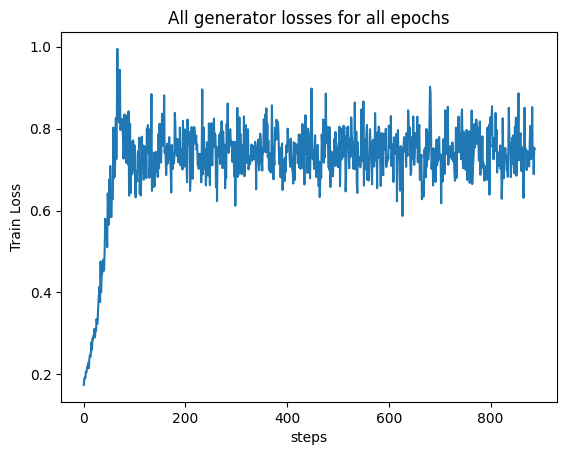

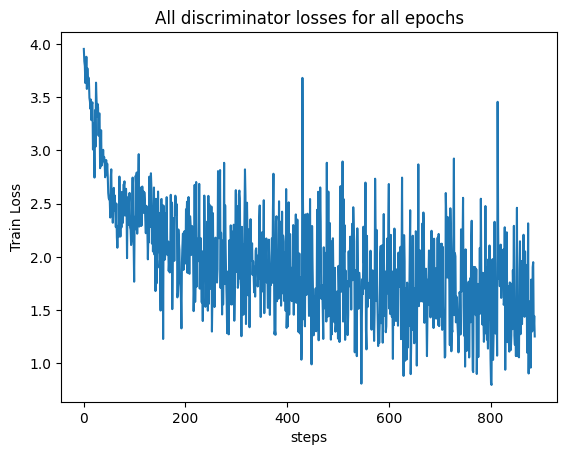

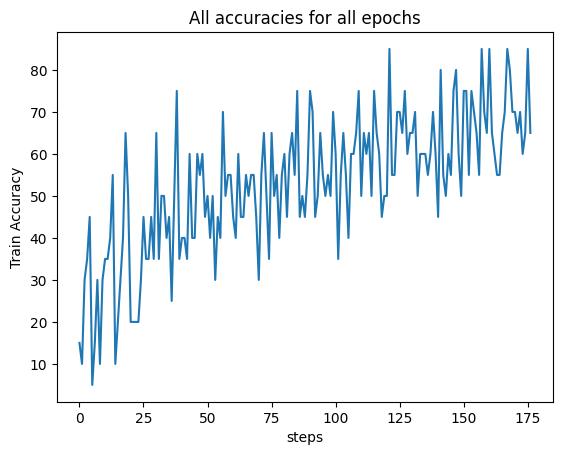

In [ ]:
toc = time.time()

print("Elapsed time is",round(toc-tic,5),"seconds")


plt.plot(generator_train_loss_for_all_epochs)
plt.title("All generator losses for all epochs")
plt.ylabel("Train Loss")
plt.xlabel("steps")

plt.show()

plt.plot(discriminator_train_loss_for_all_epochs)
plt.title("All discriminator losses for all epochs")
plt.ylabel("Train Loss")
plt.xlabel("steps")

plt.show()

plt.plot(total_acc_for_all_epochs)
plt.title("All accuracies for all epochs")
plt.ylabel("Train Accuracy")
plt.xlabel("steps")

plt.show()



In [ ]:

tic = time.time()


bert_model.eval() #maybe redundant
discriminator_network.eval()

# Tracking variables
total_test_accuracy = 0

total_test_loss = 0
nb_test_steps = 0

all_preds = []
all_labels_ids = []

#loss
nll_loss = torch.nn.CrossEntropyLoss(ignore_index=-1)

# Evaluate data for one epoch
discriminator_train_loss_for_all_epochs=[]
total_acc_for_all_epochs=[]

i=0

for batch in test_loader:
    input_ids, attention_mask, token_type_ids, label, mask = batch
    i=i+1

    # Tell pytorch not to bother with constructing the compute graph during
    # the forward pass, since this is only needed for backprop (training).
    with torch.no_grad():


        output_bert = bert_model(input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)


        features_bert = torch.squeeze(output_bert[0][:,-1,:])


        features_discriminator, last_linear_discriminator, output_discriminator = discriminator_network(features_bert)



        # Finally, we separate the discriminator's output for the real and fake
        # data
        #⛔️

        logits_list = torch.split(last_linear_discriminator, batch_size)
        D_real_logits = logits_list[0]


        probs_list = torch.split(output_discriminator, batch_size)
        D_real_probs = probs_list[0]
        #⛔️

        # Disciminator's LOSS estimation
        logits = D_real_logits[:,0:-1]
        log_probs = F.log_softmax(logits, dim=-1)


        # The discriminator provides an output for labeled and unlabeled real data
        # so the loss evaluated for unlabeled data is ignored (masked)


        ############## Plan 1
        label2one_hot = torch.nn.functional.one_hot(label, len(np.unique(all_labels)))
        per_example_loss = -torch.sum(label2one_hot * log_probs, dim=-1)
        log_probs_masked = torch.masked_select(per_example_loss, torch.tensor(mask,dtype=bool))

        masked_labelsss = torch.masked_select(label, torch.tensor(mask,dtype=bool))
        #D_L_Supervised=F.cross_entropy(log_probs_masked,masked_labelsss)

        D_L_Supervised=F.cross_entropy(log_probs_masked.to(torch.float32),masked_labelsss.to(torch.float32))






        ######## Plan 2
        # label2one_hot = torch.nn.functional.one_hot(label, len(np.unique(all_labels)))
        # per_example_loss = -torch.sum(label2one_hot * log_probs, dim=-1)
        # per_example_loss = torch.masked_select(per_example_loss, torch.tensor(mask,dtype=bool))
        # labeled_example_count = per_example_loss.type(torch.float32).numel()

        # # It may be the case that a batch does not contain labeled examples,
        # # so the "supervised loss" in this case is not evaluated
        # if labeled_example_count == 0:
        #   D_L_Supervised = 0
        # else:
        #   D_L_Supervised = torch.div(torch.sum(per_example_loss.to(device)), labeled_example_count)


        All_discriminator_losses = D_L_Supervised



        #All_generator_losses+All_discriminator_losses.backward(retain_graph=True)


        discriminator_train_loss_for_all_epochs.append(All_discriminator_losses.item())


        ## Determining the predicted labels:
        _, preds = torch.max(D_real_probs, dim = 1)
        total_samples += label.size(0)
        total_correct += (preds == label).sum().item()
        all_preds.append(preds)
        if i%5 == 0:
          acc=100*total_correct/total_samples
          total_acc_for_all_epochs.append(acc)
          print("Step:",i,"From",len(train_dataset)//batch_size)
          print('Preds:',preds,"Labels:",label)
          print("Test Accuracy For 20 Steps: ",acc,"%")
          print("\n","Discriminator's loss: ", All_discriminator_losses.item())

          total_correct=0
          total_samples=0



RuntimeError: The size of tensor a (4) must match the size of tensor b (3) at non-singleton dimension 0

In [ ]:
# label2one_hot = torch.nn.functional.one_hot(label, len(np.unique(all_labels)))
# print(log_probs.shape)
# print(label2one_hot.shape)

# per_example_loss = -torch.sum(label2one_hot * log_probs, dim=-1)


# print(per_example_loss)

torch.Size([4, 6])
torch.Size([8, 6])


RuntimeError: The size of tensor a (8) must match the size of tensor b (4) at non-singleton dimension 0

In [ ]:
toc = time.time()

print("Elapsed time is",round(toc-tic,5),"seconds")

average_loss =torch.mean(torch.tensor(All_discriminator_losses))
average_acc =torch.mean(torch.tensor(total_acc_for_all_epochs))
print("Average Test Loss:",average_loss,"\nAverage Test Accuracy:",average_acc,"%")


Elapsed time is 153.67273 seconds
Average Test Loss: tensor(20.1371, device='cuda:0') 
Average Test Accuracy: tensor(25.9185) %


<ipython-input-68-0aa2c02cc219>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  average_loss =torch.mean(torch.tensor(All_discriminator_losses))


In [ ]:
# import torch
# import torch.nn as nn
# import torch.nn.functional as F
# from transformers import BertForSequenceClassification, get_linear_schedule_with_warmup
# import time

# # Define Generator and Discriminator classes

# # class Generator(nn.Module):
# #     def __init__(self, noise_dim, hidden_layers, output_layer):
# #         super(Generator, self).__init__()
# #         self.Generator_Network = nn.Sequential(
# #             nn.Linear(noise_dim, hidden_layers[0]),
# #             nn.LeakyReLU(0.2),
# #             nn.Dropout(p=0.1),
# #             nn.Linear(hidden_layers[0], hidden_layers[1]),
# #             nn.LeakyReLU(0.2),
# #             nn.Dropout(p=0.1),
# #             nn.Linear(hidden_layers[1], hidden_layers[2]),
# #             nn.LeakyReLU(0.2),
# #             nn.Dropout(p=0.1),
# #             nn.Linear(hidden_layers[2], hidden_layers[3]),
# #             nn.LeakyReLU(0.2),
# #             nn.Dropout(p=0.1),
# #             nn.Linear(hidden_layers[3], output_layer)
# #         )

# #     def forward(self, x):
# #         return self.Generator_Network(x)


# # class Discriminator(nn.Module):
# #     def __init__(self, input_dim, hidden_layers, output_layer):
# #         super(Discriminator, self).__init__()
# #         self.Discriminator_Features = nn.Sequential(
# #             nn.Dropout(p=0.1),
# #             nn.Linear(input_dim, hidden_layers[0]),
# #             nn.Linear(hidden_layers[0], hidden_layers[1]),
# #             nn.LeakyReLU(0.2),
# #             nn.Dropout(p=0.1),
# #             nn.Linear(hidden_layers[1], hidden_layers[2]),
# #             nn.LeakyReLU(0.2),
# #             nn.Dropout(p=0.1),
# #             nn.Linear(hidden_layers[2], hidden_layers[3]),
# #             nn.LeakyReLU(0.2),
# #             nn.Dropout(p=0.1),
# #         )
# #         self.last_linear = nn.Linear(hidden_layers[3], output_layer)
# #         self.softmax = nn.Softmax(dim=-1)

# #     def forward(self, x):
# #         features = self.Discriminator_Features(x)
# #         last_linear_val = self.last_linear(features)
# #         output = self.softmax(last_linear_val)
# #         return features, last_linear_val, output


# # # Instantiate models
# # noise_dim = 100  # Adjust as needed
# # hidden_layers_gen = [256, 512, 256, 128]
# # hidden_layers_disc = [128, 256, 128, 64]
# # output_layer_gen = 768  # Should match BERT's output dimension
# # output_layer_disc = 7  # 6 classes for BERT + 1 for real/fake

# # generator_network = Generator(noise_dim, hidden_layers_gen, output_layer_gen)
# # discriminator_network = Discriminator(output_layer_gen + output_layer_disc, hidden_layers_disc, output_layer_disc)

# # Instantiate BERT model
# # bert_model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=output_layer_gen)

# # bert_model=to_device(bert_model,device)
# # generator_network=to_device(generator_network,device)
# # discriminator_network=to_device(discriminator_network,device)

# # Define optimizer and learning rate
# learning_rate_discriminator = 5e-5
# learning_rate_generator = 5e-5

# discriminator_optimizer = torch.optim.AdamW(discriminator_network.parameters(), lr=learning_rate_discriminator)
# generator_optimizer = torch.optim.AdamW(generator_network.parameters(), lr=learning_rate_generator)

# epochs=3

# # Define schedulers
# total_steps = len(train_dataset) * epochs

# scheduler_discriminator = get_linear_schedule_with_warmup(
#     discriminator_optimizer,
#     num_warmup_steps=0,
#     num_training_steps=total_steps
# )

# scheduler_generator = get_linear_schedule_with_warmup(
#     generator_optimizer,
#     num_warmup_steps=0,
#     num_training_steps=total_steps
# )

# # Training loop
# # epochs = 10  # Adjust as needed

# for epoch in range(epochs):
#     generator_network.train()
#     discriminator_network.train()
#     total_samples = 0
#     total_correct = 0

#     generator_train_loss = []
#     discriminator_train_loss = []

#     for batch in train_loader:
#         input_ids, attention_mask, token_type_ids, label, mask = batch

#         batch_size = len(input_ids)

#         output_bert = bert_model(input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)

#         features_bert = output_bert[-1]

#         all_noises = torch.zeros(batch_size, noise_dim).to(device)
#         noise = torch.randn(batch_size, noise_dim).to(device)
#         output_generator = generator_network(noise)

#         input_discriminator = torch.cat([features_bert, output_generator], dim=0)
#         print(input_discriminator.shape)
#         features_discriminator, last_linear_discriminator, output_discriminator = discriminator_network(input_discriminator)

#         # ... (rest of your code)

#         # Backward and optimization steps
#         generator_optimizer.zero_grad()
#         discriminator_optimizer.zero_grad()

#         All_generator_losses.backward(retain_graph=True)
#         All_discriminator_losses.backward()

#         generator_optimizer.step()
#         discriminator_optimizer.step()
#         scheduler_generator.step()
#         scheduler_discriminator.step()

#     # Evaluation
#     with torch.no_grad():
#         discriminator_network.eval()
#         generator_network.eval()

#         # ... (rest of your evaluation code)

#     # Print epoch-wise metrics
#     print("Epoch:", epoch, "\n",
#           "Average generator's loss in an epoch: ", torch.mean(generator_train_loss),
#           "Average discriminator's loss in an epoch: ", torch.mean(discriminator_train_loss))


In [ ]:
# import torch
# import torch.nn as nn
# import torch.nn.functional as F
# from transformers import BertForSequenceClassification, get_linear_schedule_with_warmup
# import time
# from tqdm import tqdm

# # ... (your other imports)

# # Define Generator and Discriminator classes

# class Generator(nn.Module):
#     def __init__(self, noise_dim, hidden_layers, output_layer):
#         super(Generator, self).__init__()
#         self.Generator_Network = nn.Sequential(
#             nn.Linear(noise_dim, hidden_layers[0]),
#             nn.LeakyReLU(0.2),
#             nn.Dropout(p=0.1),
#             nn.Linear(hidden_layers[0], hidden_layers[1]),
#             nn.LeakyReLU(0.2),
#             nn.Dropout(p=0.1),
#             nn.Linear(hidden_layers[1], hidden_layers[2]),
#             nn.LeakyReLU(0.2),
#             nn.Dropout(p=0.1),
#             nn.Linear(hidden_layers[2], hidden_layers[3]),
#             nn.LeakyReLU(0.2),
#             nn.Dropout(p=0.1),
#             nn.Linear(hidden_layers[3], output_layer)
#         )

#     def forward(self, x):
#         return self.Generator_Network(x)

# class Discriminator(nn.Module):
#     def __init__(self, input_dim, hidden_layers, output_layer):
#         super(Discriminator, self).__init__()
#         self.Discriminator_Features = nn.Sequential(
#             nn.Dropout(p=0.1),
#             nn.Linear(input_dim, hidden_layers[0]),
#             nn.Linear(hidden_layers[0], hidden_layers[1]),
#             nn.LeakyReLU(0.2),
#             nn.Dropout(p=0.1),
#             nn.Linear(hidden_layers[1], hidden_layers[2]),
#             nn.LeakyReLU(0.2),
#             nn.Dropout(p=0.1),
#             nn.Linear(hidden_layers[2], hidden_layers[3]),
#             nn.LeakyReLU(0.2),
#             nn.Dropout(p=0.1),
#         )
#         self.last_linear = nn.Linear(hidden_layers[3], output_layer)
#         self.softmax = nn.Softmax(dim=-1)

#     def forward(self, x):
#         features = self.Discriminator_Features(x)
#         last_linear_val = self.last_linear(features)
#         output = self.softmax(last_linear_val)
#         return features, last_linear_val, output

# # Instantiate models
# noise_dim = 100
# hidden_layers_gen = [256, 512, 256, 128]
# hidden_layers_disc = [128, 256, 128, 64]
# output_layer_gen = 768
# output_layer_disc = 7

# generator_network = Generator(noise_dim, hidden_layers_gen, output_layer_gen)
# discriminator_network = Discriminator(output_layer_gen + output_layer_disc, hidden_layers_disc, output_layer_disc)

# # Instantiate BERT model
# bert_model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=output_layer_gen)

# # ... (rest of your code)

# # Training loop
# epochs = 10
epsilon=1e-8
for epoch in range(epochs):
    generator_network.train()
    discriminator_network.train()
    total_samples = 0
    total_correct = 0
    total_acc = []
    i = 0

    for batch in train_loader:
        input_ids, attention_mask, token_type_ids, label, mask = batch
        i += 1

        batch_size = len(input_ids)

        if all(mask):  ## Simplified condition
            output_bert = bert_model(input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids, labels=label)
        else:
            output_bert = bert_model(input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)

        features_bert = output_bert[-1]

        all_noises = torch.zeros(batch_size, noise_dim).to(device)
        noise = torch.randn(batch_size, noise_dim).to(device)
        output_generator = generator_network(noise)

        input_discriminator = torch.cat([features_bert, output_generator], dim=0)

        features_discriminator, last_linear_discriminator, output_discriminator = discriminator_network(input_discriminator)

        features_list = torch.split(features_discriminator, batch_size)
        D_real_features = features_list[0]
        D_fake_features = features_list[1]

        logits_list = torch.split(last_linear_discriminator, batch_size)
        D_real_logits = logits_list[0]
        D_fake_logits = logits_list[1]

        probs_list = torch.split(output_discriminator, batch_size)
        D_real_probs = probs_list[0]
        D_fake_probs = probs_list[1]

        g_loss_d = -1 * torch.mean(torch.log(1 - D_fake_probs[:, -1] + epsilon))
        generator_loss_feature_matching = torch.mean(torch.pow(torch.mean(D_real_features, dim=0) - torch.mean(D_fake_features, dim=0), 2))
        All_generator_losses = g_loss_d + generator_loss_feature_matching

        logits = D_real_logits[:, :-1]
        log_probs = F.log_softmax(logits, dim=-1)

        label2one_hot = F.one_hot(label, len(np.unique(all_labels)))  ## Using F.one_hot for consistency
        per_example_loss = -torch.sum(label2one_hot * log_probs, dim=-1)
        per_example_loss = torch.masked_select(per_example_loss, mask)
        labeled_example_count = per_example_loss.type(torch.float32).numel()

        if labeled_example_count == 0:
            D_L_Supervised = 0
        else:
            D_L_Supervised = torch.div(torch.sum(per_example_loss.to(device)), labeled_example_count)

        D_L_unsupervised1U = -1 * torch.mean(torch.log(1 - D_real_probs[:, -1] + epsilon))
        D_L_unsupervised2U = -1 * torch.mean(torch.log(D_fake_probs[:, -1] + epsilon))
        All_discriminator_losses = D_L_Supervised + D_L_unsupervised1U + D_L_unsupervised2U

        generator_optimizer.zero_grad()
        dicriminator_optimizer.zero_grad()

        All_generator_losses.backward(retain_graph=True)
        All_discriminator_losses.backward()

        generator_train_loss.append(All_generator_losses.item())
        discriminator_train_loss.append(All_discriminator_losses.item())

        generator_train_loss_for_all_epochs.append(All_generator_losses.item())
        discriminator_train_loss_for_all_epochs.append(All_discriminator_losses.item())

        generator_optimizer.step()
        dicriminator_optimizer.step()
        scheduler_generator.step()
        scheduler_discriminator.step()

        _, preds = torch.max(D_real_probs, dim=1)
        total_samples += label.size(0)
        total_correct += (preds == label).sum().item()

        if i%5 == 0:
          acc=100*total_correct/total_samples
          total_acc.append(acc)
          total_acc_for_all_epochs.append(acc)
          print("Step:",i,"From",len(train_dataset)//batch_size)
          print('Preds:',preds,"Labels:",label)
          print("Test Accuracy For 20 Steps: ",acc,"%")
          total_correct=0
          total_samples=0

        print("\n","Generator's loss: ", All_generator_losses.item(),"Discriminator's loss: ", All_discriminator_losses.item())


# Part4 - GAN-BERT Improvments

In [ ]:
# Batch Normalization
# Using Transformers in Generator, because it imitates from BERT which is made from transformers
# Use a deeper architecture for Generator and Discriminator
# Use LSTM network, because we have sequential data
# Use skip connections in architectures
# DCGAN, WGAN, or CycleGAN
# Grid search, random search, or Bayesian optimization
# Weight decay, or data augmentation to improve generalization and prevent overfitting.
# Gradient clipping
# Learning Rate Schedulers
# Methods for preventing mode collapse

import torch
import torch.nn as nn

class AttentionBlock(nn.Module):
    def __init__(self, in_dim, out_dim):
        super(AttentionBlock, self).__init__()
        self.attention = nn.Sequential(
            nn.Linear(in_dim, out_dim),
            nn.Softmax(dim=-1)
        )

    def forward(self, x):
        attention_weights = self.attention(x)
        attended_features = torch.sum(x * torch.concat((attention_weights,attention_weights),dim=1), dim=-1)
        return attended_features

class Generator(nn.Module):
    def __init__(self, noise_dim, hidden_layers, output_layer):
        super(Generator, self).__init__()

        self.Generator_Network = nn.Sequential(
            nn.Linear(noise_dim, hidden_layers[0]),
            nn.LeakyReLU(0.2),
            nn.Dropout(p=0.1),
            nn.Linear(hidden_layers[0], output_layer),
            nn.Tanh()
        )

    def forward(self, x):
        output = self.Generator_Network(x)
        return output

class Discriminator(nn.Module):
    def __init__(self, input_dim, hidden_layers, output_layer):
        super(Discriminator, self).__init__()

        self.Discriminator_Features = nn.Sequential(
            nn.Dropout(p=0.1),
            nn.Linear(input_dim, hidden_layers[0]),
            nn.LeakyReLU(0.2),
            nn.Dropout(p=0.1),
            #AttentionBlock(hidden_layers[0], hidden_layers[1]),  # Adding Attention Block
            nn.Linear(hidden_layers[0], hidden_layers[2]),
            nn.LeakyReLU(0.2),
            nn.Dropout(p=0.1)
        )

        self.LSTM = nn.LSTM(hidden_layers[2], hidden_layers[3], batch_first=True)

        self.last_linear = nn.Linear(hidden_layers[3], output_layer)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        features = self.Discriminator_Features(x)

        lstm_input = features.unsqueeze(1)  # Adding time dimension

        lstm_output, _ = self.LSTM(lstm_input)

        lstm_output = lstm_output[:, -1, :]  # Taking the last output

        last_linear_val = self.last_linear(lstm_output)

        output = self.softmax(last_linear_val)

        return features, last_linear_val, output


# The output of this bert should be 768D
# bert_model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=768)
bert_model = AutoModel.from_pretrained('bert-base-uncased')

In [ ]:



# config = AutoConfig.from_pretrained(model_name)
# hidden_size = int(config.hidden_size)
# Define the number and width of hidden layers
# hidden_levels_g = [hidden_size for i in range(0, num_hidden_layers_g)]
# hidden_levels_d = [hidden_size for i in range(0, num_hidden_layers_d)]
hidden_size=512
hidden_layers_generator=[hidden_size,hidden_size//2,hidden_size//2,hidden_size]
hidden_levels_discriminator=[hidden_size,hidden_size//2,hidden_size//2,hidden_size]

# hidden_size=512
# hidden_layers_generator=[hidden_size]
# hidden_levels_discriminator=[hidden_size]


noise_dim=100
output_layer=768
generator_network = Generator(noise_dim=noise_dim, hidden_layers=hidden_layers_generator, output_layer=output_layer)

# We know that discriminator has a K+1 architecture because of its tasks which include detecting real and fake, and detecting the class
discriminator_network = Discriminator(input_dim=output_layer, hidden_layers=hidden_levels_discriminator,output_layer=len(np.unique(all_labels))+1)

generator_network=to_device(generator_network,device)
discriminator_network=to_device(discriminator_network,device)
bert_model=to_device(bert_model,device)

print(generator_network)
print("\n\n\n\n")
print(discriminator_network)


Generator(
  (Generator_Network): Sequential(
    (0): Linear(in_features=100, out_features=512, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=512, out_features=768, bias=True)
    (4): Tanh()
  )
)





Discriminator(
  (Discriminator_Features): Sequential(
    (0): Dropout(p=0.1, inplace=False)
    (1): Linear(in_features=768, out_features=512, bias=True)
    (2): LeakyReLU(negative_slope=0.2)
    (3): Dropout(p=0.1, inplace=False)
    (4): Linear(in_features=512, out_features=256, bias=True)
    (5): LeakyReLU(negative_slope=0.2)
    (6): Dropout(p=0.1, inplace=False)
  )
  (LSTM): LSTM(256, 512, batch_first=True)
  (last_linear): Linear(in_features=512, out_features=7, bias=True)
  (softmax): Softmax(dim=1)
)


In [ ]:
#################### COPY OF UPPER PROGRAM ( Does not contain cross entropy loss!)



import torch.nn.functional as F
tic = time.time()
epochs = 3

#models parameters
#⛔️
bert_model_vars = [i for i in bert_model.parameters()]
d_vars = bert_model_vars + [v for v in discriminator_network.parameters()]
g_vars = [v for v in generator_network.parameters()]

learning_rate_discriminator = 5e-5
learning_rate_generator = 5e-5


dicriminator_optimizer = torch.optim.AdamW(d_vars, lr=learning_rate_discriminator)
generator_optimizer = torch.optim.AdamW(g_vars, lr=learning_rate_generator)
#⛔️



#⛔️
# learning_rate_discriminator = 5e-5
# learning_rate_generator = 5e-5

# dicriminator_optimizer = torch.optim.AdamW(discriminator_network.parameters(), lr=learning_rate_discriminator)
# generator_optimizer = torch.optim.AdamW(generator_network.parameters(), lr=learning_rate_generator)
#⛔️


# num_train_examples = len(train_examples)
# num_train_steps = int(num_train_examples / batch_size * num_train_epochs)
# num_warmup_steps = int(num_train_steps * warmup_proportion)

num_warmup_steps = 0 # It was for our program! 0 !


# scheduler_d = get_constant_schedule_with_warmup(dis_optimizer,
#                                           num_warmup_steps = num_warmup_steps)
# scheduler_g = get_constant_schedule_with_warmup(gen_optimizer,
#                                           num_warmup_steps = num_warmup_steps)

total_steps = len(train_dataset) * epochs

scheduler_discriminator = get_linear_schedule_with_warmup(
  dicriminator_optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

scheduler_generator = get_linear_schedule_with_warmup(
  dicriminator_optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)


generator_train_loss_for_all_epochs=[]
discriminator_train_loss_for_all_epochs=[]
total_acc_for_all_epochs=[]

epsilon = 1e-8

all_preds=[]
for epoch in range(epochs):

    generator_train_loss=[]
    discriminator_train_loss=[]

    bert_model.train()
    generator_network.train()
    discriminator_network.train()
    total_samples = 0
    total_correct = 0
    total_acc=[]
    i=0

    for batch in train_loader_with_label:
    #for batch in train_loader:
        input_ids, attention_mask, token_type_ids, label, mask = batch
        i=i+1


        batch_size = len(input_ids)
        # print(mask)
        # if (all(mask)==True):
          # print("\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nAll are True, so we go for supervised learning!")
          # output_bert = bert_model(input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids, labels=label)
          # bert_loss=output_bert.loss
          # bert_loss.backward()


        # else:
        #   #print("Not all are True, so we go for unsupervised learning!")
        #   output_bert = bert_model(input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)


        output_bert = bert_model(input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)


        features_bert = torch.squeeze(output_bert[0][:,-1,:])

        #print(features_bert.shape)

        noise = torch.randn(batch_size,noise_dim).to(device)


        output_generator = generator_network(noise)


        input_discriminator = torch.cat([features_bert, output_generator], dim=0)
        # Then, we select the output of the disciminator
        features_discriminator, last_linear_discriminator, output_discriminator = discriminator_network(input_discriminator)

        # print("output_discriminator")
        # print(output_discriminator.shape)
        # print("\n\nlast_linear_discriminator")
        # print(last_linear_discriminator.shape)




        # Finally, we separate the discriminator's output for the real and fake
        # data
        #⛔️
        features_list = torch.split(features_discriminator, batch_size)
        D_real_features = features_list[0]
        D_fake_features = features_list[1]

        logits_list = torch.split(last_linear_discriminator, batch_size)
        D_real_logits = logits_list[0]
        D_fake_logits = logits_list[1]

        probs_list = torch.split(output_discriminator, batch_size)
        D_real_probs = probs_list[0]
        D_fake_probs = probs_list[1]
        #⛔️
        #---------------------------------
        #  LOSS evaluation
        #---------------------------------
        # Generator's LOSS estimation
        g_loss_d = -1 * torch.mean(torch.log(1 - D_fake_probs[:,-1] + epsilon))
        generator_loss_feature_matching = torch.mean(torch.pow(torch.mean(D_real_features, dim=0) - torch.mean(D_fake_features, dim=0), 2))
        All_generator_losses = g_loss_d + generator_loss_feature_matching

        # Disciminator's LOSS estimation
        logits = D_real_logits[:,0:-1]
        log_probs = F.log_softmax(logits, dim=-1)


        # The discriminator provides an output for labeled and unlabeled real data
        # so the loss evaluated for unlabeled data is ignored (masked)
        label2one_hot = torch.nn.functional.one_hot(label, len(np.unique(all_labels)))
        per_example_loss = -torch.sum(label2one_hot * log_probs, dim=-1)
        per_example_loss = torch.masked_select(per_example_loss, mask)
        labeled_example_count = per_example_loss.type(torch.float32).numel()

        # It may be the case that a batch does not contain labeled examples,
        # so the "supervised loss" in this case is not evaluated
        if labeled_example_count == 0:
          D_L_Supervised = 0
        else:
          D_L_Supervised = torch.div(torch.sum(per_example_loss.to(device)), labeled_example_count)

        D_L_unsupervised1U = -1 * torch.mean(torch.log(1 - D_real_probs[:, -1] + epsilon))
        D_L_unsupervised2U = -1 * torch.mean(torch.log(D_fake_probs[:, -1] + epsilon))
        All_discriminator_losses = D_L_Supervised + D_L_unsupervised1U + D_L_unsupervised2U


        generator_optimizer.zero_grad()
        dicriminator_optimizer.zero_grad()
        #⛔️
        All_generator_losses.backward(retain_graph=True)

        #All_generator_losses.backward()
        #⛔️
        All_discriminator_losses.backward()

        #All_generator_losses+All_discriminator_losses.backward(retain_graph=True)

        generator_train_loss.append(All_generator_losses.item())
        discriminator_train_loss.append(All_discriminator_losses.item())

        generator_train_loss_for_all_epochs.append(All_generator_losses.item())
        discriminator_train_loss_for_all_epochs.append(All_discriminator_losses.item())

        generator_optimizer.step()
        dicriminator_optimizer.step()
        scheduler_generator.step()
        scheduler_discriminator.step()



        ## Determining the predicted labels:
        D_real_probs
        _, preds = torch.max(D_real_probs, dim = 1)
        total_samples += label.size(0)
        total_correct += (preds == label).sum().item()
        all_preds.append(preds)
        if i%20 == 0:
          acc=100*total_correct/total_samples
          total_acc.append(acc)
          total_acc_for_all_epochs.append(acc)
          print("Step:",i,"From",len(train_dataset)//batch_size)
          print('Preds:',preds,"Labels:",label)
          print("Test Accuracy For 20 Steps: ",acc,"%")
          print("\n","Generator's loss: ", All_generator_losses.item(),"Discriminator's loss: ", All_discriminator_losses.item())

          total_correct=0
          total_samples=0



    print("Epoch:",epoch,"\n","Average generator's loss in an epoch: ", np.mean(generator_train_loss),"Average discriminator's loss in an epoch: ", np.mean(discriminator_train_loss),"Average accuracy:",np.mean(total_acc),"%")



Step: 20 From 1056
Preds: tensor([5, 5, 5, 5], device='cuda:0') Labels: tensor([2, 0, 1, 4], device='cuda:0')
Test Accuracy For 20 Steps:  13.75 %

 Generator's loss:  0.1612485647201538 Discriminator's loss:  3.8752307891845703
Step: 40 From 1056
Preds: tensor([5, 0, 0, 5], device='cuda:0') Labels: tensor([4, 3, 0, 2], device='cuda:0')
Test Accuracy For 20 Steps:  15.0 %

 Generator's loss:  0.1969611644744873 Discriminator's loss:  3.7423157691955566
Step: 60 From 1056
Preds: tensor([0, 6, 6, 6], device='cuda:0') Labels: tensor([3, 5, 4, 1], device='cuda:0')
Test Accuracy For 20 Steps:  13.75 %

 Generator's loss:  0.4406450390815735 Discriminator's loss:  3.2047581672668457
Step: 80 From 1056
Preds: tensor([6, 6, 6, 6], device='cuda:0') Labels: tensor([3, 1, 1, 4], device='cuda:0')
Test Accuracy For 20 Steps:  0.0 %

 Generator's loss:  0.813095211982727 Discriminator's loss:  2.7088451385498047
Step: 100 From 1056
Preds: tensor([6, 6, 6, 0], device='cuda:0') Labels: tensor([4, 5, 1

KeyboardInterrupt: 

Elapsed time is 611.44716 seconds


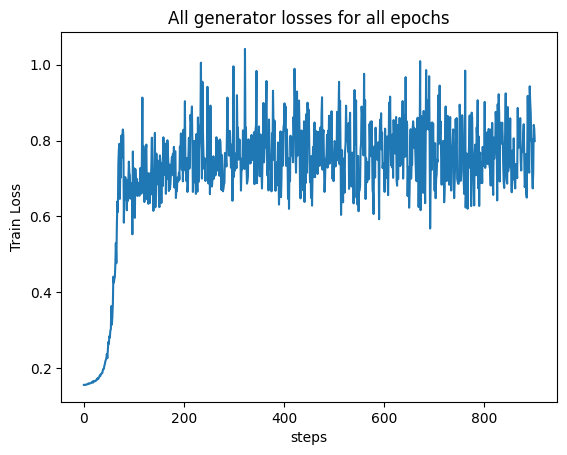

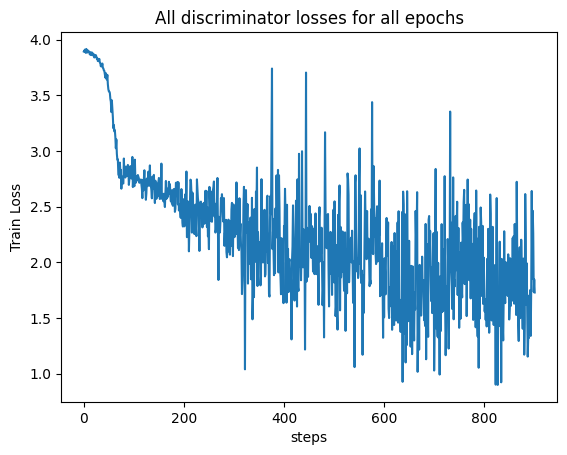

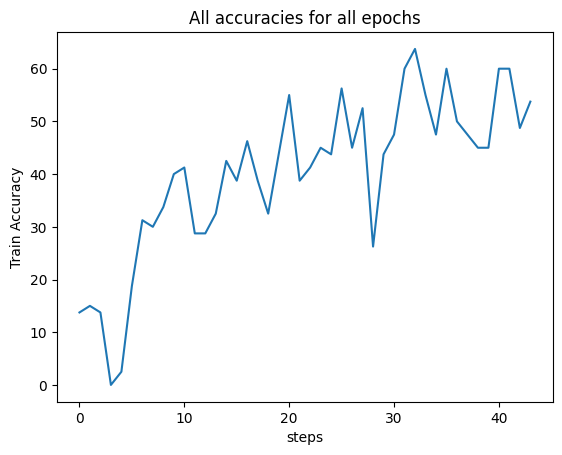

In [ ]:
toc = time.time()

print("Elapsed time is",round(toc-tic,5),"seconds")


plt.plot(generator_train_loss_for_all_epochs)
plt.title("All generator losses for all epochs")
plt.ylabel("Train Loss")
plt.xlabel("steps")

plt.show()

plt.plot(discriminator_train_loss_for_all_epochs)
plt.title("All discriminator losses for all epochs")
plt.ylabel("Train Loss")
plt.xlabel("steps")

plt.show()

plt.plot(total_acc_for_all_epochs)
plt.title("All accuracies for all epochs")
plt.ylabel("Train Accuracy")
plt.xlabel("steps")

plt.show()



In [ ]:

tic = time.time()


bert_model.eval() #maybe redundant
discriminator_network.eval()

# Tracking variables
total_test_accuracy = 0

total_test_loss = 0
nb_test_steps = 0

all_preds = []
all_labels_ids = []

#loss
nll_loss = torch.nn.CrossEntropyLoss(ignore_index=-1)

# Evaluate data for one epoch
discriminator_train_loss_for_all_epochs=[]
total_acc_for_all_epochs=[]

i=0

for batch in test_loader:
    input_ids, attention_mask, token_type_ids, label, mask = batch
    i=i+1

    # Tell pytorch not to bother with constructing the compute graph during
    # the forward pass, since this is only needed for backprop (training).
    with torch.no_grad():


        output_bert = bert_model(input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)


        features_bert = torch.squeeze(output_bert[0][:,-1,:])


        features_discriminator, last_linear_discriminator, output_discriminator = discriminator_network(features_bert)



        # Finally, we separate the discriminator's output for the real and fake
        # data
        #⛔️

        logits_list = torch.split(last_linear_discriminator, batch_size)
        D_real_logits = logits_list[0]


        probs_list = torch.split(output_discriminator, batch_size)
        D_real_probs = probs_list[0]
        #⛔️

        # Disciminator's LOSS estimation
        logits = D_real_logits[:,0:-1]
        log_probs = F.log_softmax(logits, dim=-1)


        # The discriminator provides an output for labeled and unlabeled real data
        # so the loss evaluated for unlabeled data is ignored (masked)


        ############## Plan 1
        label2one_hot = torch.nn.functional.one_hot(label, len(np.unique(all_labels)))
        per_example_loss = -torch.sum(label2one_hot * log_probs, dim=-1)
        log_probs_masked = torch.masked_select(per_example_loss, torch.tensor(mask,dtype=bool))

        masked_labelsss = torch.masked_select(label, torch.tensor(mask,dtype=bool))
        #D_L_Supervised=F.cross_entropy(log_probs_masked,masked_labelsss)

        D_L_Supervised=F.cross_entropy(log_probs_masked.to(torch.float32),masked_labelsss.to(torch.float32))






        ######## Plan 2
        # label2one_hot = torch.nn.functional.one_hot(label, len(np.unique(all_labels)))
        # per_example_loss = -torch.sum(label2one_hot * log_probs, dim=-1)
        # per_example_loss = torch.masked_select(per_example_loss, torch.tensor(mask,dtype=bool))
        # labeled_example_count = per_example_loss.type(torch.float32).numel()

        # # It may be the case that a batch does not contain labeled examples,
        # # so the "supervised loss" in this case is not evaluated
        # if labeled_example_count == 0:
        #   D_L_Supervised = 0
        # else:
        #   D_L_Supervised = torch.div(torch.sum(per_example_loss.to(device)), labeled_example_count)


        All_discriminator_losses = D_L_Supervised



        #All_generator_losses+All_discriminator_losses.backward(retain_graph=True)


        discriminator_train_loss_for_all_epochs.append(All_discriminator_losses.item())


        ## Determining the predicted labels:
        _, preds = torch.max(D_real_probs, dim = 1)
        total_samples += label.size(0)
        total_correct += (preds == label).sum().item()
        all_preds.append(preds)
        if i%5 == 0:
          acc=100*total_correct/total_samples
          total_acc_for_all_epochs.append(acc)
          print("Step:",i,"From",len(train_dataset)//batch_size)
          print('Preds:',preds,"Labels:",label)
          print("Test Accuracy For 20 Steps: ",acc,"%")
          print("\n","Discriminator's loss: ", All_discriminator_losses.item())

          total_correct=0
          total_samples=0



<ipython-input-42-f6222a1ca7dc>:68: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  log_probs_masked = torch.masked_select(per_example_loss, torch.tensor(mask,dtype=bool))
<ipython-input-42-f6222a1ca7dc>:70: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  masked_labelsss = torch.masked_select(label, torch.tensor(mask,dtype=bool))


Step: 5 From 1056
Preds: tensor([4, 5, 1, 3], device='cuda:0') Labels: tensor([0, 0, 1, 5], device='cuda:0')
Test Accuracy For 20 Steps:  53.94736842105263 %

 Discriminator's loss:  9.967192649841309
Step: 10 From 1056
Preds: tensor([1, 1, 3, 1], device='cuda:0') Labels: tensor([2, 1, 5, 3], device='cuda:0')
Test Accuracy For 20 Steps:  45.0 %

 Discriminator's loss:  15.272095680236816
Step: 15 From 1056
Preds: tensor([5, 5, 3, 5], device='cuda:0') Labels: tensor([0, 3, 5, 5], device='cuda:0')
Test Accuracy For 20 Steps:  25.0 %

 Discriminator's loss:  19.046058654785156
Step: 20 From 1056
Preds: tensor([1, 5, 4, 2], device='cuda:0') Labels: tensor([1, 2, 0, 2], device='cuda:0')
Test Accuracy For 20 Steps:  45.0 %

 Discriminator's loss:  9.012436866760254
Step: 25 From 1056
Preds: tensor([5, 2, 3, 4], device='cuda:0') Labels: tensor([0, 3, 5, 4], device='cuda:0')
Test Accuracy For 20 Steps:  45.0 %

 Discriminator's loss:  23.189407348632812
Step: 30 From 1056
Preds: tensor([3, 5, 

In [ ]:
toc = time.time()

print("Elapsed time is",round(toc-tic,5),"seconds")

average_loss =torch.mean(torch.tensor(All_discriminator_losses))
average_acc =torch.mean(torch.tensor(total_acc_for_all_epochs))
print("Average Test Loss:",average_loss,"\nAverage Test Accuracy:",average_acc,"%")


Elapsed time is 139.06302 seconds
Average Test Loss: tensor(16.4972, device='cuda:0') 
Average Test Accuracy: tensor(41.4596) %


<ipython-input-43-0aa2c02cc219>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  average_loss =torch.mean(torch.tensor(All_discriminator_losses))
